# LightGBM
### Parameters:
System:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
    * **speed** (*land speed*)
        * **other speeds**: fly, climb, swim
    * **num immunities**
    * **resistances**: fire, cold, electricity, acid, piercing, slashing, physical, bludgeoning, mental, poison, all-damage
    * **weaknesses**: cold-iron, good, fire, cold, area-damage, splash-damage, evil, slashing
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

Items
* **items**
    * **melee**
    * **ranged**
    * **spells nr**

### Prediction: *level*

## Loading data

In [38]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
    "land_speed",
    "num_immunities",
    "fly",
    "swim",
    "climb",
    "fire_resistance",
    "cold_resistance",
    "electricity_resistance",
    "acid_resistance",
    "piercing_resistance",
    "slashing_resistance",
    "physical_resistance",
    "bludgeoning_resistance",
    "mental_resistance",
    "poison_resistance",
    "all-damage_resistance",
    "cold-iron_weakness",
    "good_weakness",
    "fire_weakness",
    "cold_weakness",
    "area-damage_weakness",
    "splash-damage_weakness",
    "evil_weakness",
    "slashing_weakness",
    "melee",
    "ranged",
    "spells",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   will                    1206 non-null   int64  
 1   str                     1206 non-null   int64  
 2   land_speed              1206 non-null   float64
 3   wis                     1206 non-null   int64  
 4   num_immunities          1206 non-null   int64  
 5   fortitude               1206 non-null   int64  
 6   book                    1206 non-null   object 
 7   int                     1206 non-null   int64  
 8   cha                     1206 non-null   int64  
 9   con                     1206 non-null   int64  
 10  level                   1206 non-null   int64  
 11  dex                     1206 non-null   int64  
 12  reflex                  1206 non-null   int64  
 13  focus                   1206 non-null   int32  
 14  ac                      1206 non-null   

In [40]:
df.head()

,will,str,land_speed,wis,num_immunities,fortitude,book,int,cha,con,...,spells_nr_lvl_4,spells_nr_lvl_5,spells_nr_lvl_6,spells_nr_lvl_7,spells_nr_lvl_8,spells_nr_lvl_9,melee_max_bonus,avg_melee_dmg,ranged_max_bonus,avg_ranged_dmg
0,17,7,30.0,2,3,22,Pathfinder Bestiary,1,1,5,...,0,0,0,0,0,0,23,22.0,0,0.0
1,16,9,35.0,2,0,21,Pathfinder Bestiary,-4,1,5,...,0,0,0,0,0,0,23,22.0,0,0.0
2,15,7,30.0,3,0,20,Pathfinder Bestiary,-4,-2,6,...,0,0,0,0,0,0,21,16.0,0,0.0
3,32,7,50.0,5,3,30,Pathfinder Bestiary,6,6,5,...,1,0,1,0,0,0,33,31.5,0,0.0
4,4,-5,0.0,1,0,6,Pathfinder Bestiary,-1,1,1,...,1,0,0,0,0,0,0,0.0,8,5.0


###### Level

In [41]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [42]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [43]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


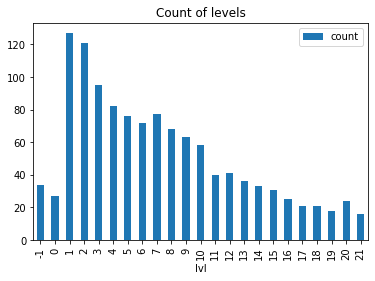

In [44]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [45]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [46]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [47]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [48]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [49]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 45
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.460853	valid_0's l2: 0.927292


In [50]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.93
RMSE: 0.96
MAE: 0.46


In [52]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "full", mse, rmse, mae]

In [53]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.12
RMSE test: 0.96


###### MAE by level

In [54]:
from training.results import plot_mae_by_level

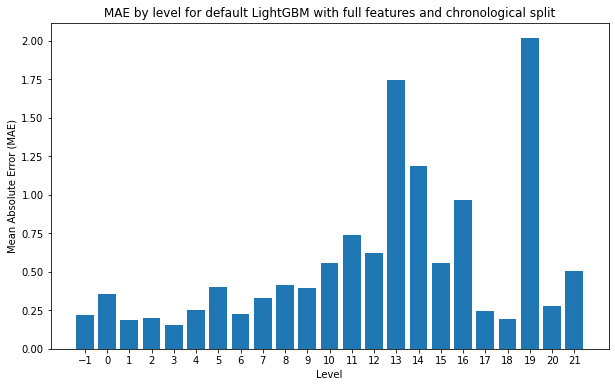

In [55]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with full features and chronological split",
)

In [56]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 0.93
RMSE: 0.96

Round type: round
MSE: 0.96
RMSE: 0.98

Round type: 0.33
MSE: 0.91
RMSE: 0.95

Round type: 0.45
MSE: 0.93
RMSE: 0.96



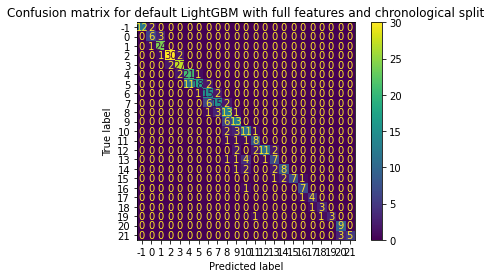

In [57]:
plot_confusion_matrix(
    "round",
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with full features and chronological split",
)

#### Tuning

In [58]:
from training.results import assess_regression_model

In [59]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-04 19:52:35,824] A new study created in memory with name: no-name-52efcfef-b829-462a-a18a-8e3a738d94d4

feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.143226 + 0.0274718
[200]	cv_agg's l2: 0.139761 + 0.0257463
[300]	cv_agg's l2: 0.139617 + 0.0253988
[400]	cv_agg's l2: 0.138896 + 0.0249516
[500]	cv_agg's l2: 0.138986 + 0.0249003



feature_fraction, val_score: 0.138834:  14%|######4                                      | 1/7 [00:12<01:13, 12.21s/it][I 2023-11-04 19:52:48,039] Trial 0 finished with value: 0.13883441613825528 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.13883441613825528.

feature_fraction, val_score: 0.138834:  14%|######4                                      | 1/7 [00:12<01:13, 12.21s/it]

Early stopping, best iteration is:
[430]	cv_agg's l2: 0.138834 + 0.0249718
[100]	cv_agg's l2: 0.143342 + 0.0239797
[200]	cv_agg's l2: 0.140238 + 0.0234299
[300]	cv_agg's l2: 0.139853 + 0.0235772
[400]	cv_agg's l2: 0.139916 + 0.0237211
[500]	cv_agg's l2: 0.139519 + 0.023493



feature_fraction, val_score: 0.138834:  29%|############8                                | 2/7 [00:23<00:57, 11.45s/it][I 2023-11-04 19:52:58,963] Trial 1 finished with value: 0.13968288591681682 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.13883441613825528.

feature_fraction, val_score: 0.138834:  29%|############8                                | 2/7 [00:23<00:57, 11.45s/it]

Early stopping, best iteration is:
[430]	cv_agg's l2: 0.138834 + 0.0249718
[100]	cv_agg's l2: 0.147361 + 0.0370218
[200]	cv_agg's l2: 0.143437 + 0.0355216
[300]	cv_agg's l2: 0.143001 + 0.0353305
[400]	cv_agg's l2: 0.142542 + 0.0351108
[500]	cv_agg's l2: 0.142675 + 0.0351279



feature_fraction, val_score: 0.138834:  43%|###################2                         | 3/7 [00:31<00:40, 10.05s/it][I 2023-11-04 19:53:07,356] Trial 2 finished with value: 0.1425815787225122 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.13883441613825528.

feature_fraction, val_score: 0.138834:  43%|###################2                         | 3/7 [00:31<00:40, 10.05s/it]

Early stopping, best iteration is:
[430]	cv_agg's l2: 0.138834 + 0.0249718
[100]	cv_agg's l2: 0.144599 + 0.0348907
[200]	cv_agg's l2: 0.142487 + 0.0341496
[300]	cv_agg's l2: 0.142289 + 0.0339189
[400]	cv_agg's l2: 0.142245 + 0.0337876
[500]	cv_agg's l2: 0.142225 + 0.0339503



feature_fraction, val_score: 0.138834:  57%|#########################7                   | 4/7 [00:39<00:27,  9.28s/it][I 2023-11-04 19:53:15,453] Trial 3 finished with value: 0.14224330560529527 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.13883441613825528.

feature_fraction, val_score: 0.138834:  57%|#########################7                   | 4/7 [00:39<00:27,  9.28s/it]

Early stopping, best iteration is:
[430]	cv_agg's l2: 0.138834 + 0.0249718
[100]	cv_agg's l2: 0.145423 + 0.0351758
[200]	cv_agg's l2: 0.142405 + 0.0336349
[300]	cv_agg's l2: 0.14211 + 0.0334071
[400]	cv_agg's l2: 0.141997 + 0.0335231
[500]	cv_agg's l2: 0.141934 + 0.0333443



feature_fraction, val_score: 0.138834:  71%|################################1            | 5/7 [00:48<00:17,  8.98s/it][I 2023-11-04 19:53:23,908] Trial 4 finished with value: 0.1419775640101284 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.13883441613825528.

feature_fraction, val_score: 0.138834:  71%|################################1            | 5/7 [00:48<00:17,  8.98s/it]

Early stopping, best iteration is:
[430]	cv_agg's l2: 0.138834 + 0.0249718
[100]	cv_agg's l2: 0.146059 + 0.0337964
[200]	cv_agg's l2: 0.142107 + 0.0333569
[300]	cv_agg's l2: 0.141597 + 0.0335288
[400]	cv_agg's l2: 0.141392 + 0.0340433
[500]	cv_agg's l2: 0.141295 + 0.0340412



feature_fraction, val_score: 0.138834:  86%|######################################5      | 6/7 [00:56<00:08,  8.74s/it][I 2023-11-04 19:53:32,195] Trial 5 finished with value: 0.14131639882062486 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.13883441613825528.

feature_fraction, val_score: 0.138834:  86%|######################################5      | 6/7 [00:56<00:08,  8.74s/it]

Early stopping, best iteration is:
[430]	cv_agg's l2: 0.138834 + 0.0249718
[100]	cv_agg's l2: 0.152702 + 0.0348887
[200]	cv_agg's l2: 0.150122 + 0.0340851
[300]	cv_agg's l2: 0.149888 + 0.0341901
[400]	cv_agg's l2: 0.149884 + 0.0343955
[500]	cv_agg's l2: 0.149861 + 0.0344915



feature_fraction, val_score: 0.138834: 100%|#############################################| 7/7 [01:04<00:00,  9.24s/it]


Early stopping, best iteration is:
[430]	cv_agg's l2: 0.138834 + 0.0249718



num_leaves, val_score: 0.138834:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.143226 + 0.0274718
[200]	cv_agg's l2: 0.139761 + 0.0257463
[300]	cv_agg's l2: 0.139617 + 0.0253988
[400]	cv_agg's l2: 0.138896 + 0.0249516
[500]	cv_agg's l2: 0.138986 + 0.0249003



num_leaves, val_score: 0.138834:   5%|##5                                               | 1/20 [00:10<03:22, 10.66s/it][I 2023-11-04 19:53:51,184] Trial 7 finished with value: 0.13883441613825528 and parameters: {'num_leaves': 70}. Best is trial 7 with value: 0.13883441613825528.

num_leaves, val_score: 0.138834:   5%|##5                                               | 1/20 [00:10<03:22, 10.66s/it]

Early stopping, best iteration is:
[430]	cv_agg's l2: 0.138834 + 0.0249718
[100]	cv_agg's l2: 0.143226 + 0.0274718
[200]	cv_agg's l2: 0.139761 + 0.0257463
[300]	cv_agg's l2: 0.139617 + 0.0253988
[400]	cv_agg's l2: 0.138896 + 0.0249516
[500]	cv_agg's l2: 0.138986 + 0.0249003



num_leaves, val_score: 0.138834:  10%|#####                                             | 2/20 [00:20<03:01, 10.06s/it][I 2023-11-04 19:54:00,828] Trial 8 finished with value: 0.13883441613825528 and parameters: {'num_leaves': 41}. Best is trial 7 with value: 0.13883441613825528.

num_leaves, val_score: 0.138834:  10%|#####                                             | 2/20 [00:20<03:01, 10.06s/it]

Early stopping, best iteration is:
[430]	cv_agg's l2: 0.138834 + 0.0249718
[100]	cv_agg's l2: 0.143226 + 0.0274718
[200]	cv_agg's l2: 0.139761 + 0.0257463
[300]	cv_agg's l2: 0.139617 + 0.0253988
[400]	cv_agg's l2: 0.138896 + 0.0249516
[500]	cv_agg's l2: 0.138986 + 0.0249003



num_leaves, val_score: 0.138834:  15%|#######5                                          | 3/20 [00:29<02:47,  9.85s/it][I 2023-11-04 19:54:10,435] Trial 9 finished with value: 0.13883441613825528 and parameters: {'num_leaves': 244}. Best is trial 7 with value: 0.13883441613825528.

num_leaves, val_score: 0.138834:  15%|#######5                                          | 3/20 [00:29<02:47,  9.85s/it]

Early stopping, best iteration is:
[430]	cv_agg's l2: 0.138834 + 0.0249718
[100]	cv_agg's l2: 0.143226 + 0.0274718
[200]	cv_agg's l2: 0.139761 + 0.0257463
[300]	cv_agg's l2: 0.139617 + 0.0253988
[400]	cv_agg's l2: 0.138896 + 0.0249516
[500]	cv_agg's l2: 0.138986 + 0.0249003



num_leaves, val_score: 0.138834:  20%|##########                                        | 4/20 [00:39<02:35,  9.74s/it][I 2023-11-04 19:54:20,011] Trial 10 finished with value: 0.13883441613825528 and parameters: {'num_leaves': 217}. Best is trial 7 with value: 0.13883441613825528.

num_leaves, val_score: 0.138834:  20%|##########                                        | 4/20 [00:39<02:35,  9.74s/it]

Early stopping, best iteration is:
[430]	cv_agg's l2: 0.138834 + 0.0249718
[100]	cv_agg's l2: 0.143226 + 0.0274718
[200]	cv_agg's l2: 0.139761 + 0.0257463
[300]	cv_agg's l2: 0.139617 + 0.0253988
[400]	cv_agg's l2: 0.138896 + 0.0249516
[500]	cv_agg's l2: 0.138986 + 0.0249003



num_leaves, val_score: 0.138834:  25%|############5                                     | 5/20 [00:49<02:25,  9.68s/it][I 2023-11-04 19:54:29,566] Trial 11 finished with value: 0.13883441613825528 and parameters: {'num_leaves': 58}. Best is trial 7 with value: 0.13883441613825528.

num_leaves, val_score: 0.138834:  25%|############5                                     | 5/20 [00:49<02:25,  9.68s/it]

Early stopping, best iteration is:
[430]	cv_agg's l2: 0.138834 + 0.0249718
[100]	cv_agg's l2: 0.143226 + 0.0274718
[200]	cv_agg's l2: 0.139761 + 0.0257463
[300]	cv_agg's l2: 0.139617 + 0.0253988
[400]	cv_agg's l2: 0.138896 + 0.0249516
[500]	cv_agg's l2: 0.138986 + 0.0249003



num_leaves, val_score: 0.138834:  30%|###############                                   | 6/20 [01:00<02:22, 10.21s/it][I 2023-11-04 19:54:40,799] Trial 12 finished with value: 0.13883441613825528 and parameters: {'num_leaves': 126}. Best is trial 7 with value: 0.13883441613825528.

num_leaves, val_score: 0.138834:  30%|###############                                   | 6/20 [01:00<02:22, 10.21s/it]

Early stopping, best iteration is:
[430]	cv_agg's l2: 0.138834 + 0.0249718
[100]	cv_agg's l2: 0.143226 + 0.0274718
[200]	cv_agg's l2: 0.139761 + 0.0257463
[300]	cv_agg's l2: 0.139617 + 0.0253988
[400]	cv_agg's l2: 0.138896 + 0.0249516
[500]	cv_agg's l2: 0.138986 + 0.0249003



num_leaves, val_score: 0.138834:  35%|#################5                                | 7/20 [01:10<02:12, 10.16s/it][I 2023-11-04 19:54:50,864] Trial 13 finished with value: 0.13883441613825528 and parameters: {'num_leaves': 127}. Best is trial 7 with value: 0.13883441613825528.

num_leaves, val_score: 0.138834:  35%|#################5                                | 7/20 [01:10<02:12, 10.16s/it]

Early stopping, best iteration is:
[430]	cv_agg's l2: 0.138834 + 0.0249718
[100]	cv_agg's l2: 0.143374 + 0.024833
[200]	cv_agg's l2: 0.139422 + 0.023665
[300]	cv_agg's l2: 0.138523 + 0.0228675



num_leaves, val_score: 0.138482:  40%|####################                              | 8/20 [01:16<01:47,  9.00s/it][I 2023-11-04 19:54:57,366] Trial 14 finished with value: 0.13848199037616393 and parameters: {'num_leaves': 22}. Best is trial 14 with value: 0.13848199037616393.

num_leaves, val_score: 0.138482:  40%|####################                              | 8/20 [01:16<01:47,  9.00s/it]

[400]	cv_agg's l2: 0.138804 + 0.0231052
Early stopping, best iteration is:
[308]	cv_agg's l2: 0.138482 + 0.0227962
[100]	cv_agg's l2: 0.143374 + 0.024833
[200]	cv_agg's l2: 0.139422 + 0.023665
[300]	cv_agg's l2: 0.138523 + 0.0228675



num_leaves, val_score: 0.138482:  45%|######################5                           | 9/20 [01:24<01:35,  8.70s/it][I 2023-11-04 19:55:05,418] Trial 15 finished with value: 0.13848199037616393 and parameters: {'num_leaves': 22}. Best is trial 14 with value: 0.13848199037616393.

num_leaves, val_score: 0.138482:  45%|######################5                           | 9/20 [01:24<01:35,  8.70s/it]

[400]	cv_agg's l2: 0.138804 + 0.0231052
Early stopping, best iteration is:
[308]	cv_agg's l2: 0.138482 + 0.0227962
[100]	cv_agg's l2: 0.15737 + 0.0143887
[200]	cv_agg's l2: 0.143581 + 0.0146931
[300]	cv_agg's l2: 0.139735 + 0.0146909
[400]	cv_agg's l2: 0.13834 + 0.0154067
[500]	cv_agg's l2: 0.137771 + 0.0152317
[600]	cv_agg's l2: 0.136736 + 0.0154345
[700]	cv_agg's l2: 0.136345 + 0.0152083
[800]	cv_agg's l2: 0.135969 + 0.0157557



num_leaves, val_score: 0.135935:  50%|########################5                        | 10/20 [01:30<01:18,  7.82s/it][I 2023-11-04 19:55:11,276] Trial 16 finished with value: 0.13593476790423925 and parameters: {'num_leaves': 7}. Best is trial 16 with value: 0.13593476790423925.

num_leaves, val_score: 0.135935:  50%|########################5                        | 10/20 [01:30<01:18,  7.82s/it]

Early stopping, best iteration is:
[792]	cv_agg's l2: 0.135935 + 0.015645
[100]	cv_agg's l2: 0.286762 + 0.0361807
[200]	cv_agg's l2: 0.254607 + 0.0309342
[300]	cv_agg's l2: 0.245873 + 0.030162
[400]	cv_agg's l2: 0.24076 + 0.0282028
[500]	cv_agg's l2: 0.236438 + 0.0267881
[600]	cv_agg's l2: 0.233492 + 0.026095
[700]	cv_agg's l2: 0.230844 + 0.0261337
[800]	cv_agg's l2: 0.227967 + 0.0262606



num_leaves, val_score: 0.135935:  55%|##########################9                      | 11/20 [01:33<00:56,  6.26s/it][I 2023-11-04 19:55:13,999] Trial 17 finished with value: 0.22828714422253643 and parameters: {'num_leaves': 2}. Best is trial 16 with value: 0.13593476790423925.

num_leaves, val_score: 0.135935:  55%|##########################9                      | 11/20 [01:33<00:56,  6.26s/it]

Early stopping, best iteration is:
[792]	cv_agg's l2: 0.135935 + 0.015645
[100]	cv_agg's l2: 0.143226 + 0.0274718
[200]	cv_agg's l2: 0.139761 + 0.0257463
[300]	cv_agg's l2: 0.139617 + 0.0253988
[400]	cv_agg's l2: 0.138896 + 0.0249516
[500]	cv_agg's l2: 0.138986 + 0.0249003
[600]	cv_agg's l2: 0.139171 + 0.0250363
[700]	cv_agg's l2: 0.139201 + 0.0250553
[800]	cv_agg's l2: 0.139284 + 0.0249805



num_leaves, val_score: 0.135935:  60%|#############################4                   | 12/20 [01:50<01:16,  9.60s/it][I 2023-11-04 19:55:31,225] Trial 18 finished with value: 0.13930166231981722 and parameters: {'num_leaves': 91}. Best is trial 16 with value: 0.13593476790423925.

num_leaves, val_score: 0.135935:  60%|#############################4                   | 12/20 [01:50<01:16,  9.60s/it]

Early stopping, best iteration is:
[792]	cv_agg's l2: 0.135935 + 0.015645
[100]	cv_agg's l2: 0.143226 + 0.0274718
[200]	cv_agg's l2: 0.139761 + 0.0257463
[300]	cv_agg's l2: 0.139617 + 0.0253988
[400]	cv_agg's l2: 0.138896 + 0.0249516
[500]	cv_agg's l2: 0.138986 + 0.0249003
[600]	cv_agg's l2: 0.139171 + 0.0250363
[700]	cv_agg's l2: 0.139201 + 0.0250553
[800]	cv_agg's l2: 0.139284 + 0.0249805



num_leaves, val_score: 0.135935:  65%|###############################8                 | 13/20 [02:08<01:25, 12.18s/it][I 2023-11-04 19:55:49,347] Trial 19 finished with value: 0.13930166231981722 and parameters: {'num_leaves': 169}. Best is trial 16 with value: 0.13593476790423925.

num_leaves, val_score: 0.135935:  65%|###############################8                 | 13/20 [02:08<01:25, 12.18s/it]

Early stopping, best iteration is:
[792]	cv_agg's l2: 0.135935 + 0.015645
[100]	cv_agg's l2: 0.209468 + 0.0298853
[200]	cv_agg's l2: 0.185939 + 0.0287112
[300]	cv_agg's l2: 0.173452 + 0.0278206
[400]	cv_agg's l2: 0.167958 + 0.0272722
[500]	cv_agg's l2: 0.163935 + 0.0261638
[600]	cv_agg's l2: 0.160697 + 0.02495
[700]	cv_agg's l2: 0.158686 + 0.0251574
[800]	cv_agg's l2: 0.156869 + 0.0251416



num_leaves, val_score: 0.135935:  70%|##################################3              | 14/20 [02:13<00:58,  9.77s/it][I 2023-11-04 19:55:53,539] Trial 20 finished with value: 0.15694748804775882 and parameters: {'num_leaves': 4}. Best is trial 16 with value: 0.13593476790423925.

num_leaves, val_score: 0.135935:  70%|##################################3              | 14/20 [02:13<00:58,  9.77s/it]

Early stopping, best iteration is:
[792]	cv_agg's l2: 0.135935 + 0.015645
[100]	cv_agg's l2: 0.143226 + 0.0274718
[200]	cv_agg's l2: 0.139761 + 0.0257463
[300]	cv_agg's l2: 0.139617 + 0.0253988
[400]	cv_agg's l2: 0.138896 + 0.0249516
[500]	cv_agg's l2: 0.138986 + 0.0249003
[600]	cv_agg's l2: 0.139171 + 0.0250363
[700]	cv_agg's l2: 0.139201 + 0.0250553
[800]	cv_agg's l2: 0.139284 + 0.0249805



num_leaves, val_score: 0.135935:  75%|####################################7            | 15/20 [02:36<01:09, 13.85s/it][I 2023-11-04 19:56:16,857] Trial 21 finished with value: 0.13930166231981722 and parameters: {'num_leaves': 34}. Best is trial 16 with value: 0.13593476790423925.

num_leaves, val_score: 0.135935:  75%|####################################7            | 15/20 [02:36<01:09, 13.85s/it]

Early stopping, best iteration is:
[792]	cv_agg's l2: 0.135935 + 0.015645
[100]	cv_agg's l2: 0.14341 + 0.0253106
[200]	cv_agg's l2: 0.139874 + 0.0243246
[300]	cv_agg's l2: 0.138942 + 0.023436
[400]	cv_agg's l2: 0.138776 + 0.0235668
[500]	cv_agg's l2: 0.138599 + 0.0233234
[600]	cv_agg's l2: 0.138482 + 0.0233633
[700]	cv_agg's l2: 0.138374 + 0.0232462
[800]	cv_agg's l2: 0.13842 + 0.0231825



num_leaves, val_score: 0.135935:  80%|#######################################2         | 16/20 [02:52<00:58, 14.58s/it][I 2023-11-04 19:56:33,145] Trial 22 finished with value: 0.1384207105713944 and parameters: {'num_leaves': 24}. Best is trial 16 with value: 0.13593476790423925.

num_leaves, val_score: 0.135935:  80%|#######################################2         | 16/20 [02:52<00:58, 14.58s/it]

Early stopping, best iteration is:
[792]	cv_agg's l2: 0.135935 + 0.015645
[100]	cv_agg's l2: 0.143226 + 0.0274718
[200]	cv_agg's l2: 0.139761 + 0.0257463
[300]	cv_agg's l2: 0.139617 + 0.0253988
[400]	cv_agg's l2: 0.138896 + 0.0249516
[500]	cv_agg's l2: 0.138986 + 0.0249003
[600]	cv_agg's l2: 0.139171 + 0.0250363
[700]	cv_agg's l2: 0.139201 + 0.0250553
[800]	cv_agg's l2: 0.139284 + 0.0249805



num_leaves, val_score: 0.135935:  85%|#########################################6       | 17/20 [03:10<00:46, 15.60s/it][I 2023-11-04 19:56:51,101] Trial 23 finished with value: 0.13930166231981722 and parameters: {'num_leaves': 90}. Best is trial 16 with value: 0.13593476790423925.

num_leaves, val_score: 0.135935:  85%|#########################################6       | 17/20 [03:10<00:46, 15.60s/it]

Early stopping, best iteration is:
[792]	cv_agg's l2: 0.135935 + 0.015645
[100]	cv_agg's l2: 0.143226 + 0.0274718
[200]	cv_agg's l2: 0.139761 + 0.0257463
[300]	cv_agg's l2: 0.139617 + 0.0253988
[400]	cv_agg's l2: 0.138896 + 0.0249516
[500]	cv_agg's l2: 0.138986 + 0.0249003
[600]	cv_agg's l2: 0.139171 + 0.0250363
[700]	cv_agg's l2: 0.139201 + 0.0250553
[800]	cv_agg's l2: 0.139284 + 0.0249805



num_leaves, val_score: 0.135935:  90%|############################################1    | 18/20 [03:28<00:32, 16.23s/it][I 2023-11-04 19:57:08,815] Trial 24 finished with value: 0.13930166231981722 and parameters: {'num_leaves': 46}. Best is trial 16 with value: 0.13593476790423925.

num_leaves, val_score: 0.135935:  90%|############################################1    | 18/20 [03:28<00:32, 16.23s/it]

Early stopping, best iteration is:
[792]	cv_agg's l2: 0.135935 + 0.015645
[100]	cv_agg's l2: 0.228737 + 0.0295953
[200]	cv_agg's l2: 0.203721 + 0.025577
[300]	cv_agg's l2: 0.189465 + 0.0227219
[400]	cv_agg's l2: 0.182166 + 0.0222539
[500]	cv_agg's l2: 0.174608 + 0.0222283
[600]	cv_agg's l2: 0.170659 + 0.0212132
[700]	cv_agg's l2: 0.165976 + 0.0193085
[800]	cv_agg's l2: 0.163632 + 0.018531



num_leaves, val_score: 0.135935:  95%|##############################################5  | 19/20 [03:31<00:12, 12.31s/it][I 2023-11-04 19:57:11,986] Trial 25 finished with value: 0.1636560158621255 and parameters: {'num_leaves': 3}. Best is trial 16 with value: 0.13593476790423925.

num_leaves, val_score: 0.135935:  95%|##############################################5  | 19/20 [03:31<00:12, 12.31s/it]

Early stopping, best iteration is:
[792]	cv_agg's l2: 0.135935 + 0.015645
[100]	cv_agg's l2: 0.143226 + 0.0274718
[200]	cv_agg's l2: 0.139761 + 0.0257463
[300]	cv_agg's l2: 0.139617 + 0.0253988
[400]	cv_agg's l2: 0.138896 + 0.0249516
[500]	cv_agg's l2: 0.138986 + 0.0249003
[600]	cv_agg's l2: 0.139171 + 0.0250363
[700]	cv_agg's l2: 0.139201 + 0.0250553
[800]	cv_agg's l2: 0.139284 + 0.0249805



num_leaves, val_score: 0.135935: 100%|#################################################| 20/20 [03:48<00:00, 11.41s/it]


Early stopping, best iteration is:
[792]	cv_agg's l2: 0.135935 + 0.015645



bagging, val_score: 0.135935:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.19759 + 0.0218531
[200]	cv_agg's l2: 0.183046 + 0.0200149
[300]	cv_agg's l2: 0.178253 + 0.0209269
[400]	cv_agg's l2: 0.173444 + 0.0212697
[500]	cv_agg's l2: 0.174819 + 0.0192499
[600]	cv_agg's l2: 0.173875 + 0.0217808
[700]	cv_agg's l2: 0.172333 + 0.020146
[800]	cv_agg's l2: 0.172601 + 0.0204162



bagging, val_score: 0.135935:  10%|#####3                                               | 1/10 [00:06<00:56,  6.31s/it][I 2023-11-04 19:57:34,961] Trial 27 finished with value: 0.17174779690795453 and parameters: {'bagging_fraction': 0.4448421637240798, 'bagging_freq': 2}. Best is trial 27 with value: 0.17174779690795453.

bagging, val_score: 0.135935:  10%|#####3                                               | 1/10 [00:06<00:56,  6.31s/it]

Early stopping, best iteration is:
[792]	cv_agg's l2: 0.135935 + 0.015645
[100]	cv_agg's l2: 0.160941 + 0.0199441
[200]	cv_agg's l2: 0.149058 + 0.018637
[300]	cv_agg's l2: 0.145225 + 0.0177404
[400]	cv_agg's l2: 0.143369 + 0.0176128
[500]	cv_agg's l2: 0.141687 + 0.0172559
[600]	cv_agg's l2: 0.140213 + 0.0172032
[700]	cv_agg's l2: 0.139773 + 0.0169301
[800]	cv_agg's l2: 0.13942 + 0.0169894



bagging, val_score: 0.135935:  20%|##########6                                          | 2/10 [00:12<00:49,  6.23s/it][I 2023-11-04 19:57:41,136] Trial 28 finished with value: 0.13952651050493947 and parameters: {'bagging_fraction': 0.9847954801088019, 'bagging_freq': 7}. Best is trial 28 with value: 0.13952651050493947.

bagging, val_score: 0.135935:  20%|##########6                                          | 2/10 [00:12<00:49,  6.23s/it]

Early stopping, best iteration is:
[792]	cv_agg's l2: 0.135935 + 0.015645
[100]	cv_agg's l2: 0.236055 + 0.0344136
[200]	cv_agg's l2: 0.209542 + 0.0395059
[300]	cv_agg's l2: 0.198021 + 0.03675
[400]	cv_agg's l2: 0.198417 + 0.0365932
[500]	cv_agg's l2: 0.194851 + 0.0364512
[600]	cv_agg's l2: 0.196922 + 0.0403646
[700]	cv_agg's l2: 0.197857 + 0.044431
[800]	cv_agg's l2: 0.195169 + 0.0417049



bagging, val_score: 0.135935:  30%|###############9                                     | 3/10 [00:19<00:44,  6.36s/it][I 2023-11-04 19:57:47,657] Trial 29 finished with value: 0.1943324588794845 and parameters: {'bagging_fraction': 0.40488522227237767, 'bagging_freq': 6}. Best is trial 28 with value: 0.13952651050493947.

bagging, val_score: 0.135935:  30%|###############9                                     | 3/10 [00:19<00:44,  6.36s/it]

Early stopping, best iteration is:
[792]	cv_agg's l2: 0.135935 + 0.015645
[100]	cv_agg's l2: 0.173548 + 0.0199886
[200]	cv_agg's l2: 0.160126 + 0.019215
[300]	cv_agg's l2: 0.156059 + 0.0188658
[400]	cv_agg's l2: 0.155252 + 0.0196729
[500]	cv_agg's l2: 0.154724 + 0.020238
[600]	cv_agg's l2: 0.1532 + 0.0196643
[700]	cv_agg's l2: 0.152701 + 0.0200748
[800]	cv_agg's l2: 0.153055 + 0.0201186



bagging, val_score: 0.135935:  40%|#####################2                               | 4/10 [00:25<00:37,  6.31s/it][I 2023-11-04 19:57:53,889] Trial 30 finished with value: 0.15327384114756754 and parameters: {'bagging_fraction': 0.7715272949041598, 'bagging_freq': 1}. Best is trial 28 with value: 0.13952651050493947.

bagging, val_score: 0.135935:  40%|#####################2                               | 4/10 [00:25<00:37,  6.31s/it]

Early stopping, best iteration is:
[792]	cv_agg's l2: 0.135935 + 0.015645
[100]	cv_agg's l2: 0.177004 + 0.0168048
[200]	cv_agg's l2: 0.162408 + 0.0151012
[300]	cv_agg's l2: 0.160302 + 0.0146704
[400]	cv_agg's l2: 0.159788 + 0.0148032
[500]	cv_agg's l2: 0.159802 + 0.0141452
[600]	cv_agg's l2: 0.160227 + 0.0122384
[700]	cv_agg's l2: 0.159642 + 0.0122742
[800]	cv_agg's l2: 0.159461 + 0.0116838



bagging, val_score: 0.135935:  50%|##########################5                          | 5/10 [00:30<00:30,  6.07s/it][I 2023-11-04 19:57:59,540] Trial 31 finished with value: 0.1590749921574783 and parameters: {'bagging_fraction': 0.6560171127141602, 'bagging_freq': 4}. Best is trial 28 with value: 0.13952651050493947.

bagging, val_score: 0.135935:  50%|##########################5                          | 5/10 [00:30<00:30,  6.07s/it]

Early stopping, best iteration is:
[792]	cv_agg's l2: 0.135935 + 0.015645
[100]	cv_agg's l2: 0.155945 + 0.0277162
[200]	cv_agg's l2: 0.143733 + 0.0267515
[300]	cv_agg's l2: 0.139366 + 0.0272696
[400]	cv_agg's l2: 0.137521 + 0.0265194
[500]	cv_agg's l2: 0.136811 + 0.0260016
[600]	cv_agg's l2: 0.135204 + 0.0254223
[700]	cv_agg's l2: 0.134534 + 0.0257756
[800]	cv_agg's l2: 0.134281 + 0.0256997



bagging, val_score: 0.134255:  60%|###############################8                     | 6/10 [00:37<00:24,  6.10s/it][I 2023-11-04 19:58:05,697] Trial 32 finished with value: 0.13425510117243072 and parameters: {'bagging_fraction': 0.951308388924916, 'bagging_freq': 4}. Best is trial 32 with value: 0.13425510117243072.

bagging, val_score: 0.134255:  60%|###############################8                     | 6/10 [00:37<00:24,  6.10s/it]

Early stopping, best iteration is:
[799]	cv_agg's l2: 0.134255 + 0.0257243
[100]	cv_agg's l2: 0.158772 + 0.0248981
[200]	cv_agg's l2: 0.149278 + 0.0223124
[300]	cv_agg's l2: 0.145552 + 0.0216784
[400]	cv_agg's l2: 0.143739 + 0.0208539
[500]	cv_agg's l2: 0.143015 + 0.0199247
[600]	cv_agg's l2: 0.142165 + 0.0194331
[700]	cv_agg's l2: 0.141653 + 0.0194388
[800]	cv_agg's l2: 0.14165 + 0.0196123



bagging, val_score: 0.134255:  70%|#####################################                | 7/10 [00:42<00:18,  6.00s/it][I 2023-11-04 19:58:11,502] Trial 33 finished with value: 0.14168607679251752 and parameters: {'bagging_fraction': 0.9740596946665687, 'bagging_freq': 4}. Best is trial 32 with value: 0.13425510117243072.

bagging, val_score: 0.134255:  70%|#####################################                | 7/10 [00:42<00:18,  6.00s/it]

Early stopping, best iteration is:
[799]	cv_agg's l2: 0.134255 + 0.0257243
[100]	cv_agg's l2: 0.168803 + 0.0264928
[200]	cv_agg's l2: 0.154198 + 0.0223096
[300]	cv_agg's l2: 0.149497 + 0.0218764
[400]	cv_agg's l2: 0.147047 + 0.021734
[500]	cv_agg's l2: 0.146285 + 0.0211559
[600]	cv_agg's l2: 0.145739 + 0.0200628
[700]	cv_agg's l2: 0.14598 + 0.019344
[800]	cv_agg's l2: 0.145116 + 0.0193787



bagging, val_score: 0.134255:  80%|##########################################4          | 8/10 [00:49<00:12,  6.22s/it][I 2023-11-04 19:58:18,186] Trial 34 finished with value: 0.145075705960798 and parameters: {'bagging_fraction': 0.8386921891729051, 'bagging_freq': 3}. Best is trial 32 with value: 0.13425510117243072.

bagging, val_score: 0.134255:  80%|##########################################4          | 8/10 [00:49<00:12,  6.22s/it]

Early stopping, best iteration is:
[799]	cv_agg's l2: 0.134255 + 0.0257243
[100]	cv_agg's l2: 0.168186 + 0.0308881
[200]	cv_agg's l2: 0.153481 + 0.0279172
[300]	cv_agg's l2: 0.148835 + 0.0282696
[400]	cv_agg's l2: 0.146025 + 0.0265269
[500]	cv_agg's l2: 0.144377 + 0.0258668
[600]	cv_agg's l2: 0.143682 + 0.025948
[700]	cv_agg's l2: 0.143079 + 0.0259833
[800]	cv_agg's l2: 0.142347 + 0.0260025



bagging, val_score: 0.134255:  90%|###############################################7     | 9/10 [00:55<00:06,  6.19s/it][I 2023-11-04 19:58:24,319] Trial 35 finished with value: 0.14231060085098463 and parameters: {'bagging_fraction': 0.8735306530724525, 'bagging_freq': 6}. Best is trial 32 with value: 0.13425510117243072.

bagging, val_score: 0.134255:  90%|###############################################7     | 9/10 [00:55<00:06,  6.19s/it]

Early stopping, best iteration is:
[799]	cv_agg's l2: 0.134255 + 0.0257243
[100]	cv_agg's l2: 0.18621 + 0.0314501
[200]	cv_agg's l2: 0.171834 + 0.029614
[300]	cv_agg's l2: 0.169324 + 0.0277926
[400]	cv_agg's l2: 0.166434 + 0.0279862
[500]	cv_agg's l2: 0.1661 + 0.0291381
[600]	cv_agg's l2: 0.165685 + 0.0285154
[700]	cv_agg's l2: 0.165168 + 0.0288271
[800]	cv_agg's l2: 0.165717 + 0.0278967



bagging, val_score: 0.134255: 100%|####################################################| 10/10 [01:01<00:00,  6.19s/it]


Early stopping, best iteration is:
[799]	cv_agg's l2: 0.134255 + 0.0257243



feature_fraction_stage2, val_score: 0.134255:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.162595 + 0.0280197
[200]	cv_agg's l2: 0.148787 + 0.0249597
[300]	cv_agg's l2: 0.143245 + 0.0244493
[400]	cv_agg's l2: 0.140452 + 0.0243096
[500]	cv_agg's l2: 0.139659 + 0.0242409
[600]	cv_agg's l2: 0.139175 + 0.0236447
[700]	cv_agg's l2: 0.138411 + 0.0233671
[800]	cv_agg's l2: 0.137882 + 0.0234365



feature_fraction_stage2, val_score: 0.134255:  17%|######3                               | 1/6 [00:06<00:31,  6.30s/it][I 2023-11-04 19:58:36,846] Trial 37 finished with value: 0.1378595054369997 and parameters: {'feature_fraction': 0.484}. Best is trial 37 with value: 0.1378595054369997.

feature_fraction_stage2, val_score: 0.134255:  17%|######3                               | 1/6 [00:06<00:31,  6.30s/it]

Early stopping, best iteration is:
[799]	cv_agg's l2: 0.134255 + 0.0257243
[100]	cv_agg's l2: 0.161399 + 0.0301303
[200]	cv_agg's l2: 0.146371 + 0.0249389
[300]	cv_agg's l2: 0.140856 + 0.0246722
[400]	cv_agg's l2: 0.137379 + 0.0229577
[500]	cv_agg's l2: 0.135719 + 0.0229265
[600]	cv_agg's l2: 0.135663 + 0.0226436
[700]	cv_agg's l2: 0.134466 + 0.0226424
[800]	cv_agg's l2: 0.134253 + 0.0224012



feature_fraction_stage2, val_score: 0.134084:  33%|############6                         | 2/6 [00:12<00:24,  6.07s/it][I 2023-11-04 19:58:42,751] Trial 38 finished with value: 0.13408413533887753 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 38 with value: 0.13408413533887753.

feature_fraction_stage2, val_score: 0.134084:  33%|############6                         | 2/6 [00:12<00:24,  6.07s/it]

Early stopping, best iteration is:
[763]	cv_agg's l2: 0.134084 + 0.0224461
[100]	cv_agg's l2: 0.16332 + 0.0437392
[200]	cv_agg's l2: 0.150751 + 0.0399188
[300]	cv_agg's l2: 0.145498 + 0.0386305
[400]	cv_agg's l2: 0.142261 + 0.0369555
[500]	cv_agg's l2: 0.141432 + 0.0366308
[600]	cv_agg's l2: 0.140307 + 0.0363034
[700]	cv_agg's l2: 0.139769 + 0.0368163
[800]	cv_agg's l2: 0.139275 + 0.0366799



feature_fraction_stage2, val_score: 0.134084:  50%|###################                   | 3/6 [00:18<00:18,  6.16s/it][I 2023-11-04 19:58:49,012] Trial 39 finished with value: 0.13943997497627306 and parameters: {'feature_fraction': 0.58}. Best is trial 38 with value: 0.13408413533887753.

feature_fraction_stage2, val_score: 0.134084:  50%|###################                   | 3/6 [00:18<00:18,  6.16s/it]

Early stopping, best iteration is:
[763]	cv_agg's l2: 0.134084 + 0.0224461
[100]	cv_agg's l2: 0.156031 + 0.0292223
[200]	cv_agg's l2: 0.145003 + 0.0279616
[300]	cv_agg's l2: 0.140296 + 0.0280958
[400]	cv_agg's l2: 0.13799 + 0.026714
[500]	cv_agg's l2: 0.137071 + 0.0262446
[600]	cv_agg's l2: 0.136111 + 0.02615
[700]	cv_agg's l2: 0.135484 + 0.025996
[800]	cv_agg's l2: 0.134571 + 0.0258289



feature_fraction_stage2, val_score: 0.134084:  67%|#########################3            | 4/6 [00:24<00:12,  6.09s/it][I 2023-11-04 19:58:54,996] Trial 40 finished with value: 0.13515833115940287 and parameters: {'feature_fraction': 0.516}. Best is trial 38 with value: 0.13408413533887753.

feature_fraction_stage2, val_score: 0.134084:  67%|#########################3            | 4/6 [00:24<00:12,  6.09s/it]

Early stopping, best iteration is:
[763]	cv_agg's l2: 0.134084 + 0.0224461
[100]	cv_agg's l2: 0.160642 + 0.0276613
[200]	cv_agg's l2: 0.148641 + 0.0261118
[300]	cv_agg's l2: 0.142875 + 0.0269252
[400]	cv_agg's l2: 0.139505 + 0.0258635
[500]	cv_agg's l2: 0.137973 + 0.0247182
[600]	cv_agg's l2: 0.137113 + 0.0244799
[700]	cv_agg's l2: 0.136304 + 0.0247595
[800]	cv_agg's l2: 0.135719 + 0.0249093



feature_fraction_stage2, val_score: 0.134084:  83%|###############################6      | 5/6 [00:30<00:05,  5.96s/it][I 2023-11-04 19:59:00,716] Trial 41 finished with value: 0.13589026982609995 and parameters: {'feature_fraction': 0.5479999999999999}. Best is trial 38 with value: 0.13408413533887753.

feature_fraction_stage2, val_score: 0.134084:  83%|###############################6      | 5/6 [00:30<00:05,  5.96s/it]

Early stopping, best iteration is:
[763]	cv_agg's l2: 0.134084 + 0.0224461
[100]	cv_agg's l2: 0.16368 + 0.0345712
[200]	cv_agg's l2: 0.147218 + 0.0295708
[300]	cv_agg's l2: 0.14121 + 0.027975
[400]	cv_agg's l2: 0.13941 + 0.0270425
[500]	cv_agg's l2: 0.13827 + 0.0259072
[600]	cv_agg's l2: 0.137525 + 0.0253856
[700]	cv_agg's l2: 0.136893 + 0.025559
[800]	cv_agg's l2: 0.136393 + 0.0252151



feature_fraction_stage2, val_score: 0.134084: 100%|######################################| 6/6 [00:35<00:00,  5.95s/it]


Early stopping, best iteration is:
[763]	cv_agg's l2: 0.134084 + 0.0224461



regularization_factors, val_score: 0.134084:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.16137 + 0.030146
[200]	cv_agg's l2: 0.147974 + 0.0241565
[300]	cv_agg's l2: 0.142729 + 0.0233377
[400]	cv_agg's l2: 0.139347 + 0.0215336
[500]	cv_agg's l2: 0.138377 + 0.0214031
[600]	cv_agg's l2: 0.137542 + 0.0210466
[700]	cv_agg's l2: 0.136584 + 0.0208738
[800]	cv_agg's l2: 0.135984 + 0.0208782



regularization_factors, val_score: 0.134084:   5%|#9                                    | 1/20 [00:05<01:44,  5.48s/it][I 2023-11-04 19:59:11,720] Trial 43 finished with value: 0.13611195985126384 and parameters: {'lambda_l1': 0.002705601227806385, 'lambda_l2': 0.0007227810900578515}. Best is trial 43 with value: 0.13611195985126384.

regularization_factors, val_score: 0.134084:   5%|#9                                    | 1/20 [00:05<01:44,  5.48s/it]

Early stopping, best iteration is:
[763]	cv_agg's l2: 0.134084 + 0.0224461
[100]	cv_agg's l2: 0.161399 + 0.0301303
[200]	cv_agg's l2: 0.146371 + 0.0249389
[300]	cv_agg's l2: 0.140856 + 0.0246722
[400]	cv_agg's l2: 0.137379 + 0.0229577
[500]	cv_agg's l2: 0.135719 + 0.0229265
[600]	cv_agg's l2: 0.135663 + 0.0226436
[700]	cv_agg's l2: 0.134466 + 0.0226424
[800]	cv_agg's l2: 0.134253 + 0.0224012



regularization_factors, val_score: 0.134084:  10%|###8                                  | 2/20 [00:11<01:40,  5.58s/it][I 2023-11-04 19:59:17,378] Trial 44 finished with value: 0.13408413536219577 and parameters: {'lambda_l1': 4.664769327183443e-08, 'lambda_l2': 1.341328532987643e-08}. Best is trial 44 with value: 0.13408413536219577.

regularization_factors, val_score: 0.134084:  10%|###8                                  | 2/20 [00:11<01:40,  5.58s/it]

Early stopping, best iteration is:
[763]	cv_agg's l2: 0.134084 + 0.0224461
[100]	cv_agg's l2: 0.161399 + 0.0301303
[200]	cv_agg's l2: 0.146371 + 0.0249389
[300]	cv_agg's l2: 0.140856 + 0.0246722
[400]	cv_agg's l2: 0.137379 + 0.0229577
[500]	cv_agg's l2: 0.135719 + 0.0229265
[600]	cv_agg's l2: 0.135663 + 0.0226436
[700]	cv_agg's l2: 0.134466 + 0.0226424
[800]	cv_agg's l2: 0.134253 + 0.0224012



regularization_factors, val_score: 0.134084:  15%|#####7                                | 3/20 [00:16<01:34,  5.58s/it][I 2023-11-04 19:59:22,964] Trial 45 finished with value: 0.1340841353489081 and parameters: {'lambda_l1': 2.253556034952482e-08, 'lambda_l2': 2.0002529235023306e-08}. Best is trial 45 with value: 0.1340841353489081.

regularization_factors, val_score: 0.134084:  15%|#####7                                | 3/20 [00:16<01:34,  5.58s/it]

Early stopping, best iteration is:
[763]	cv_agg's l2: 0.134084 + 0.0224461
[100]	cv_agg's l2: 0.161399 + 0.0301303
[200]	cv_agg's l2: 0.146371 + 0.0249389
[300]	cv_agg's l2: 0.140856 + 0.0246722
[400]	cv_agg's l2: 0.137379 + 0.0229577
[500]	cv_agg's l2: 0.135719 + 0.0229265
[600]	cv_agg's l2: 0.135663 + 0.0226436
[700]	cv_agg's l2: 0.134466 + 0.0226424
[800]	cv_agg's l2: 0.134253 + 0.0224012



regularization_factors, val_score: 0.134084:  20%|#######6                              | 4/20 [00:22<01:32,  5.81s/it][I 2023-11-04 19:59:29,108] Trial 46 finished with value: 0.13408413535855818 and parameters: {'lambda_l1': 1.5577413262591553e-08, 'lambda_l2': 1.3072697802049044e-08}. Best is trial 45 with value: 0.1340841353489081.

regularization_factors, val_score: 0.134084:  20%|#######6                              | 4/20 [00:22<01:32,  5.81s/it]

Early stopping, best iteration is:
[763]	cv_agg's l2: 0.134084 + 0.0224461
[100]	cv_agg's l2: 0.161399 + 0.0301303
[200]	cv_agg's l2: 0.146371 + 0.0249389
[300]	cv_agg's l2: 0.140856 + 0.0246722
[400]	cv_agg's l2: 0.137379 + 0.0229577
[500]	cv_agg's l2: 0.135719 + 0.0229265
[600]	cv_agg's l2: 0.135663 + 0.0226436
[700]	cv_agg's l2: 0.134466 + 0.0226424
[800]	cv_agg's l2: 0.134253 + 0.0224012



regularization_factors, val_score: 0.134084:  25%|#########5                            | 5/20 [00:31<01:41,  6.75s/it][I 2023-11-04 19:59:37,543] Trial 47 finished with value: 0.13408413535258026 and parameters: {'lambda_l1': 1.0445869788177287e-08, 'lambda_l2': 1.4901042446176167e-08}. Best is trial 45 with value: 0.1340841353489081.

regularization_factors, val_score: 0.134084:  25%|#########5                            | 5/20 [00:31<01:41,  6.75s/it]

Early stopping, best iteration is:
[763]	cv_agg's l2: 0.134084 + 0.0224461
[100]	cv_agg's l2: 0.161399 + 0.0301303
[200]	cv_agg's l2: 0.146371 + 0.0249389
[300]	cv_agg's l2: 0.140856 + 0.0246722
[400]	cv_agg's l2: 0.137379 + 0.0229577
[500]	cv_agg's l2: 0.135719 + 0.0229265
[600]	cv_agg's l2: 0.135663 + 0.0226436
[700]	cv_agg's l2: 0.134466 + 0.0226424
[800]	cv_agg's l2: 0.134253 + 0.0224012



regularization_factors, val_score: 0.134084:  30%|###########4                          | 6/20 [00:36<01:28,  6.33s/it][I 2023-11-04 19:59:43,048] Trial 48 finished with value: 0.13408413534950617 and parameters: {'lambda_l1': 1.0788705485836468e-08, 'lambda_l2': 1.544693474177689e-08}. Best is trial 45 with value: 0.1340841353489081.

regularization_factors, val_score: 0.134084:  30%|###########4                          | 6/20 [00:36<01:28,  6.33s/it]

Early stopping, best iteration is:
[763]	cv_agg's l2: 0.134084 + 0.0224461
[100]	cv_agg's l2: 0.161399 + 0.0301303
[200]	cv_agg's l2: 0.146371 + 0.0249389
[300]	cv_agg's l2: 0.140856 + 0.0246722
[400]	cv_agg's l2: 0.137379 + 0.0229577
[500]	cv_agg's l2: 0.135719 + 0.0229265
[600]	cv_agg's l2: 0.135663 + 0.0226436
[700]	cv_agg's l2: 0.134466 + 0.0226424
[800]	cv_agg's l2: 0.134253 + 0.0224012



regularization_factors, val_score: 0.134084:  35%|#############3                        | 7/20 [00:42<01:18,  6.02s/it][I 2023-11-04 19:59:48,420] Trial 49 finished with value: 0.13408413534810149 and parameters: {'lambda_l1': 1.0707085369809824e-08, 'lambda_l2': 1.046391784607597e-08}. Best is trial 49 with value: 0.13408413534810149.

regularization_factors, val_score: 0.134084:  35%|#############3                        | 7/20 [00:42<01:18,  6.02s/it]

Early stopping, best iteration is:
[763]	cv_agg's l2: 0.134084 + 0.0224461
[100]	cv_agg's l2: 0.161399 + 0.0301303
[200]	cv_agg's l2: 0.146371 + 0.0249389
[300]	cv_agg's l2: 0.140856 + 0.0246722
[400]	cv_agg's l2: 0.137379 + 0.0229577
[500]	cv_agg's l2: 0.135719 + 0.0229265
[600]	cv_agg's l2: 0.135663 + 0.0226436
[700]	cv_agg's l2: 0.134466 + 0.0226424
[800]	cv_agg's l2: 0.134253 + 0.0224012



regularization_factors, val_score: 0.134084:  40%|###############2                      | 8/20 [00:47<01:10,  5.88s/it][I 2023-11-04 19:59:54,021] Trial 50 finished with value: 0.13408413535520336 and parameters: {'lambda_l1': 1.2952789493260974e-08, 'lambda_l2': 1.8510394618808517e-08}. Best is trial 49 with value: 0.13408413534810149.

regularization_factors, val_score: 0.134084:  40%|###############2                      | 8/20 [00:47<01:10,  5.88s/it]

Early stopping, best iteration is:
[763]	cv_agg's l2: 0.134084 + 0.0224461
[100]	cv_agg's l2: 0.161399 + 0.0301303
[200]	cv_agg's l2: 0.146371 + 0.0249389
[300]	cv_agg's l2: 0.140856 + 0.0246722
[400]	cv_agg's l2: 0.137379 + 0.0229577
[500]	cv_agg's l2: 0.135719 + 0.0229265
[600]	cv_agg's l2: 0.135663 + 0.0226436
[700]	cv_agg's l2: 0.134466 + 0.0226424
[800]	cv_agg's l2: 0.134253 + 0.0224012



regularization_factors, val_score: 0.134084:  45%|#################1                    | 9/20 [00:53<01:04,  5.90s/it][I 2023-11-04 19:59:59,956] Trial 51 finished with value: 0.13408413535099886 and parameters: {'lambda_l1': 1.2793834018330343e-08, 'lambda_l2': 1.419290694508091e-08}. Best is trial 49 with value: 0.13408413534810149.

regularization_factors, val_score: 0.134084:  45%|#################1                    | 9/20 [00:53<01:04,  5.90s/it]

Early stopping, best iteration is:
[763]	cv_agg's l2: 0.134084 + 0.0224461
[100]	cv_agg's l2: 0.161399 + 0.0301303
[200]	cv_agg's l2: 0.146371 + 0.0249389
[300]	cv_agg's l2: 0.140856 + 0.0246722
[400]	cv_agg's l2: 0.137379 + 0.0229577
[500]	cv_agg's l2: 0.135719 + 0.0229265
[600]	cv_agg's l2: 0.135663 + 0.0226436
[700]	cv_agg's l2: 0.134466 + 0.0226424
[800]	cv_agg's l2: 0.134253 + 0.0224012



regularization_factors, val_score: 0.134084:  50%|##################5                  | 10/20 [00:59<00:58,  5.88s/it][I 2023-11-04 20:00:05,779] Trial 52 finished with value: 0.13408413534831912 and parameters: {'lambda_l1': 1.1853470191348615e-08, 'lambda_l2': 1.6665707026612016e-08}. Best is trial 49 with value: 0.13408413534810149.

regularization_factors, val_score: 0.134084:  50%|##################5                  | 10/20 [00:59<00:58,  5.88s/it]

Early stopping, best iteration is:
[763]	cv_agg's l2: 0.134084 + 0.0224461
[100]	cv_agg's l2: 0.161399 + 0.0301303
[200]	cv_agg's l2: 0.146371 + 0.0249389
[300]	cv_agg's l2: 0.140856 + 0.0246722
[400]	cv_agg's l2: 0.137379 + 0.0229577
[500]	cv_agg's l2: 0.135719 + 0.0229265
[600]	cv_agg's l2: 0.135663 + 0.0226436
[700]	cv_agg's l2: 0.134466 + 0.0226424
[800]	cv_agg's l2: 0.134253 + 0.0224012



regularization_factors, val_score: 0.134084:  55%|####################3                | 11/20 [01:05<00:52,  5.80s/it][I 2023-11-04 20:00:11,393] Trial 53 finished with value: 0.13408413533748326 and parameters: {'lambda_l1': 1.005765036062372e-08, 'lambda_l2': 1.1364712115891439e-08}. Best is trial 53 with value: 0.13408413533748326.

regularization_factors, val_score: 0.134084:  55%|####################3                | 11/20 [01:05<00:52,  5.80s/it]

Early stopping, best iteration is:
[763]	cv_agg's l2: 0.134084 + 0.0224461
[100]	cv_agg's l2: 0.161399 + 0.0301303
[200]	cv_agg's l2: 0.146371 + 0.0249389
[300]	cv_agg's l2: 0.140856 + 0.0246722
[400]	cv_agg's l2: 0.137283 + 0.0229925
[500]	cv_agg's l2: 0.135728 + 0.0229235
[600]	cv_agg's l2: 0.13563 + 0.0226557
[700]	cv_agg's l2: 0.134303 + 0.022696
[800]	cv_agg's l2: 0.134043 + 0.022472
[900]	cv_agg's l2: 0.133879 + 0.022309



regularization_factors, val_score: 0.133843:  60%|######################2              | 12/20 [01:12<00:49,  6.16s/it][I 2023-11-04 20:00:18,387] Trial 54 finished with value: 0.13384287421541394 and parameters: {'lambda_l1': 1.1854870005861222e-06, 'lambda_l2': 1.103985571859969e-06}. Best is trial 54 with value: 0.13384287421541394.

regularization_factors, val_score: 0.133843:  60%|######################2              | 12/20 [01:12<00:49,  6.16s/it]

[1000]	cv_agg's l2: 0.134037 + 0.0226802
Early stopping, best iteration is:
[901]	cv_agg's l2: 0.133843 + 0.022328
[100]	cv_agg's l2: 0.161399 + 0.0301303
[200]	cv_agg's l2: 0.146371 + 0.0249389
[300]	cv_agg's l2: 0.140856 + 0.0246722
[400]	cv_agg's l2: 0.137283 + 0.0229925
[500]	cv_agg's l2: 0.135728 + 0.0229235
[600]	cv_agg's l2: 0.13563 + 0.0226557
[700]	cv_agg's l2: 0.134303 + 0.022696
[800]	cv_agg's l2: 0.134043 + 0.022472
[900]	cv_agg's l2: 0.133879 + 0.022309



regularization_factors, val_score: 0.133843:  65%|########################             | 13/20 [01:18<00:43,  6.24s/it][I 2023-11-04 20:00:24,819] Trial 55 finished with value: 0.13384287384806964 and parameters: {'lambda_l1': 2.2661193171309973e-06, 'lambda_l2': 2.6382286094320443e-06}. Best is trial 55 with value: 0.13384287384806964.

regularization_factors, val_score: 0.133843:  65%|########################             | 13/20 [01:18<00:43,  6.24s/it]

[1000]	cv_agg's l2: 0.134012 + 0.022684
Early stopping, best iteration is:
[901]	cv_agg's l2: 0.133843 + 0.022328
[100]	cv_agg's l2: 0.161399 + 0.0301303
[200]	cv_agg's l2: 0.146371 + 0.0249389
[300]	cv_agg's l2: 0.140856 + 0.0246722
[400]	cv_agg's l2: 0.137283 + 0.0229925
[500]	cv_agg's l2: 0.135728 + 0.0229235
[600]	cv_agg's l2: 0.13563 + 0.0226557
[700]	cv_agg's l2: 0.134303 + 0.022696
[800]	cv_agg's l2: 0.134043 + 0.022472
[900]	cv_agg's l2: 0.133879 + 0.022309



regularization_factors, val_score: 0.133843:  70%|#########################9           | 14/20 [01:25<00:38,  6.44s/it][I 2023-11-04 20:00:31,725] Trial 56 finished with value: 0.13384287385367297 and parameters: {'lambda_l1': 3.006058262666938e-06, 'lambda_l2': 3.4042603126725067e-06}. Best is trial 55 with value: 0.13384287384806964.

regularization_factors, val_score: 0.133843:  70%|#########################9           | 14/20 [01:25<00:38,  6.44s/it]

[1000]	cv_agg's l2: 0.134012 + 0.022684
Early stopping, best iteration is:
[901]	cv_agg's l2: 0.133843 + 0.022328
[100]	cv_agg's l2: 0.161399 + 0.0301303
[200]	cv_agg's l2: 0.146371 + 0.0249389
[300]	cv_agg's l2: 0.140856 + 0.0246722
[400]	cv_agg's l2: 0.137283 + 0.0229925
[500]	cv_agg's l2: 0.135728 + 0.0229235
[600]	cv_agg's l2: 0.13563 + 0.0226557
[700]	cv_agg's l2: 0.134303 + 0.022696
[800]	cv_agg's l2: 0.134043 + 0.022472
[900]	cv_agg's l2: 0.133879 + 0.022309



regularization_factors, val_score: 0.133843:  75%|###########################7         | 15/20 [01:33<00:34,  6.82s/it][I 2023-11-04 20:00:39,430] Trial 57 finished with value: 0.13384287450231858 and parameters: {'lambda_l1': 3.729763654505112e-06, 'lambda_l2': 3.5022649849000923e-06}. Best is trial 55 with value: 0.13384287384806964.

regularization_factors, val_score: 0.133843:  75%|###########################7         | 15/20 [01:33<00:34,  6.82s/it]

[1000]	cv_agg's l2: 0.134012 + 0.022684
Early stopping, best iteration is:
[901]	cv_agg's l2: 0.133843 + 0.022328
[100]	cv_agg's l2: 0.161399 + 0.0301303
[200]	cv_agg's l2: 0.146371 + 0.0249389
[300]	cv_agg's l2: 0.140856 + 0.0246722
[400]	cv_agg's l2: 0.137283 + 0.0229925
[500]	cv_agg's l2: 0.135728 + 0.0229235
[600]	cv_agg's l2: 0.13563 + 0.0226557
[700]	cv_agg's l2: 0.134303 + 0.022696
[800]	cv_agg's l2: 0.134043 + 0.022472
[900]	cv_agg's l2: 0.133879 + 0.022309



regularization_factors, val_score: 0.133843:  80%|#############################6       | 16/20 [01:38<00:25,  6.34s/it][I 2023-11-04 20:00:44,651] Trial 58 finished with value: 0.13384287573638737 and parameters: {'lambda_l1': 4.664855077040602e-06, 'lambda_l2': 2.6135531488755213e-06}. Best is trial 55 with value: 0.13384287384806964.

regularization_factors, val_score: 0.133843:  80%|#############################6       | 16/20 [01:38<00:25,  6.34s/it]

[1000]	cv_agg's l2: 0.134012 + 0.022684
Early stopping, best iteration is:
[901]	cv_agg's l2: 0.133843 + 0.022328
[100]	cv_agg's l2: 0.161399 + 0.0301303
[200]	cv_agg's l2: 0.146371 + 0.0249389
[300]	cv_agg's l2: 0.140856 + 0.0246722
[400]	cv_agg's l2: 0.137283 + 0.0229925
[500]	cv_agg's l2: 0.135728 + 0.0229235
[600]	cv_agg's l2: 0.13563 + 0.0226557
[700]	cv_agg's l2: 0.134303 + 0.022696
[800]	cv_agg's l2: 0.134043 + 0.022472
[900]	cv_agg's l2: 0.133879 + 0.022309



regularization_factors, val_score: 0.133843:  85%|###############################4     | 17/20 [01:43<00:17,  5.91s/it][I 2023-11-04 20:00:49,570] Trial 59 finished with value: 0.13384287524069105 and parameters: {'lambda_l1': 4.732384804425056e-06, 'lambda_l2': 3.680919067324291e-06}. Best is trial 55 with value: 0.13384287384806964.

regularization_factors, val_score: 0.133843:  85%|###############################4     | 17/20 [01:43<00:17,  5.91s/it]

[1000]	cv_agg's l2: 0.134012 + 0.022684
Early stopping, best iteration is:
[901]	cv_agg's l2: 0.133843 + 0.022328
[100]	cv_agg's l2: 0.161399 + 0.0301303
[200]	cv_agg's l2: 0.146371 + 0.0249389
[300]	cv_agg's l2: 0.140856 + 0.0246722
[400]	cv_agg's l2: 0.137283 + 0.0229925
[500]	cv_agg's l2: 0.135728 + 0.0229235
[600]	cv_agg's l2: 0.13563 + 0.0226557
[700]	cv_agg's l2: 0.134303 + 0.022696
[800]	cv_agg's l2: 0.134043 + 0.022472
[900]	cv_agg's l2: 0.133879 + 0.022309



regularization_factors, val_score: 0.133843:  90%|#################################3   | 18/20 [01:48<00:11,  5.59s/it][I 2023-11-04 20:00:54,404] Trial 60 finished with value: 0.1338428748043589 and parameters: {'lambda_l1': 3.983103799031133e-06, 'lambda_l2': 3.445328258479213e-06}. Best is trial 55 with value: 0.13384287384806964.

regularization_factors, val_score: 0.133843:  90%|#################################3   | 18/20 [01:48<00:11,  5.59s/it]

[1000]	cv_agg's l2: 0.134012 + 0.022684
Early stopping, best iteration is:
[901]	cv_agg's l2: 0.133843 + 0.022328
[100]	cv_agg's l2: 0.161399 + 0.0301303
[200]	cv_agg's l2: 0.146371 + 0.0249389
[300]	cv_agg's l2: 0.140856 + 0.0246722
[400]	cv_agg's l2: 0.137283 + 0.0229925
[500]	cv_agg's l2: 0.135728 + 0.0229235
[600]	cv_agg's l2: 0.13563 + 0.0226557
[700]	cv_agg's l2: 0.134303 + 0.022696
[800]	cv_agg's l2: 0.134043 + 0.022472
[900]	cv_agg's l2: 0.133879 + 0.022309



regularization_factors, val_score: 0.133843:  95%|###################################1 | 19/20 [01:53<00:05,  5.38s/it][I 2023-11-04 20:00:59,282] Trial 61 finished with value: 0.13384287288131438 and parameters: {'lambda_l1': 1.873252557053856e-06, 'lambda_l2': 3.598873117232185e-06}. Best is trial 61 with value: 0.13384287288131438.

regularization_factors, val_score: 0.133843:  95%|###################################1 | 19/20 [01:53<00:05,  5.38s/it]

[1000]	cv_agg's l2: 0.134012 + 0.022684
Early stopping, best iteration is:
[901]	cv_agg's l2: 0.133843 + 0.022328
[100]	cv_agg's l2: 0.161399 + 0.0301303
[200]	cv_agg's l2: 0.146371 + 0.0249389
[300]	cv_agg's l2: 0.140856 + 0.0246722
[400]	cv_agg's l2: 0.137283 + 0.0229925
[500]	cv_agg's l2: 0.135728 + 0.0229235
[600]	cv_agg's l2: 0.13563 + 0.0226557
[700]	cv_agg's l2: 0.134303 + 0.022696
[800]	cv_agg's l2: 0.134043 + 0.022472
[900]	cv_agg's l2: 0.133879 + 0.022309



regularization_factors, val_score: 0.133843: 100%|#####################################| 20/20 [01:57<00:00,  5.89s/it]


[1000]	cv_agg's l2: 0.134012 + 0.022684
Early stopping, best iteration is:
[901]	cv_agg's l2: 0.133843 + 0.022328



min_data_in_leaf, val_score: 0.133843:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.176593 + 0.0255529
[200]	cv_agg's l2: 0.163848 + 0.0239742
[300]	cv_agg's l2: 0.156286 + 0.0223724
[400]	cv_agg's l2: 0.154756 + 0.0211911
[500]	cv_agg's l2: 0.153818 + 0.0211261
[600]	cv_agg's l2: 0.15304 + 0.0203048
[700]	cv_agg's l2: 0.152505 + 0.0195164
[800]	cv_agg's l2: 0.152272 + 0.0195408
[900]	cv_agg's l2: 0.15282 + 0.018893



min_data_in_leaf, val_score: 0.133843:  20%|#########                                    | 1/5 [00:04<00:19,  4.83s/it][I 2023-11-04 20:01:08,957] Trial 63 finished with value: 0.15279779517592787 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.15279779517592787.

min_data_in_leaf, val_score: 0.133843:  20%|#########                                    | 1/5 [00:04<00:19,  4.83s/it]

[1000]	cv_agg's l2: 0.15352 + 0.0191579
Early stopping, best iteration is:
[901]	cv_agg's l2: 0.133843 + 0.022328
[100]	cv_agg's l2: 0.816454 + 0.147104
[200]	cv_agg's l2: 0.755997 + 0.151595
[300]	cv_agg's l2: 0.724514 + 0.155145
[400]	cv_agg's l2: 0.710852 + 0.157701
[500]	cv_agg's l2: 0.699458 + 0.152098
[600]	cv_agg's l2: 0.691655 + 0.152652
[700]	cv_agg's l2: 0.685054 + 0.152907
[800]	cv_agg's l2: 0.679257 + 0.150051
[900]	cv_agg's l2: 0.675196 + 0.14738



min_data_in_leaf, val_score: 0.133843:  40%|##################                           | 2/5 [00:08<00:12,  4.19s/it][I 2023-11-04 20:01:12,699] Trial 64 finished with value: 0.6751869411334664 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.15279779517592787.

min_data_in_leaf, val_score: 0.133843:  40%|##################                           | 2/5 [00:08<00:12,  4.19s/it]

[1000]	cv_agg's l2: 0.672068 + 0.148407
Early stopping, best iteration is:
[901]	cv_agg's l2: 0.133843 + 0.022328
[100]	cv_agg's l2: 0.145949 + 0.0234498
[200]	cv_agg's l2: 0.13409 + 0.0198041
[300]	cv_agg's l2: 0.12934 + 0.0187698
[400]	cv_agg's l2: 0.12808 + 0.0184069
[500]	cv_agg's l2: 0.12729 + 0.0180735
[600]	cv_agg's l2: 0.126219 + 0.0172145



min_data_in_leaf, val_score: 0.126190:  60%|###########################                  | 3/5 [00:12<00:07,  3.89s/it][I 2023-11-04 20:01:16,227] Trial 65 finished with value: 0.12619008813950788 and parameters: {'min_child_samples': 10}. Best is trial 65 with value: 0.12619008813950788.

min_data_in_leaf, val_score: 0.126190:  60%|###########################                  | 3/5 [00:12<00:07,  3.89s/it]

[700]	cv_agg's l2: 0.126424 + 0.0171986
Early stopping, best iteration is:
[601]	cv_agg's l2: 0.12619 + 0.0172129
[100]	cv_agg's l2: 0.248449 + 0.0268022
[200]	cv_agg's l2: 0.222253 + 0.027592
[300]	cv_agg's l2: 0.21484 + 0.0290462
[400]	cv_agg's l2: 0.212562 + 0.0311952
[500]	cv_agg's l2: 0.212636 + 0.0319615
[600]	cv_agg's l2: 0.211405 + 0.0319773



min_data_in_leaf, val_score: 0.126190:  80%|####################################         | 4/5 [00:15<00:03,  3.71s/it][I 2023-11-04 20:01:19,669] Trial 66 finished with value: 0.21149502331854433 and parameters: {'min_child_samples': 50}. Best is trial 65 with value: 0.12619008813950788.

min_data_in_leaf, val_score: 0.126190:  80%|####################################         | 4/5 [00:15<00:03,  3.71s/it]

[700]	cv_agg's l2: 0.211314 + 0.033842
Early stopping, best iteration is:
[601]	cv_agg's l2: 0.12619 + 0.0172129
[100]	cv_agg's l2: 0.147764 + 0.025507
[200]	cv_agg's l2: 0.136429 + 0.0207649
[300]	cv_agg's l2: 0.132173 + 0.0199626
[400]	cv_agg's l2: 0.131445 + 0.0198889
[500]	cv_agg's l2: 0.131258 + 0.0200009
[600]	cv_agg's l2: 0.130021 + 0.0202605



min_data_in_leaf, val_score: 0.126190: 100%|#############################################| 5/5 [00:19<00:00,  3.81s/it]

[700]	cv_agg's l2: 0.129742 + 0.0205697
Early stopping, best iteration is:
[601]	cv_agg's l2: 0.12619 + 0.0172129


In [60]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.12619008813950788
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.873252557053856e-06
    lambda_l2: 3.598873117232185e-06
    num_leaves: 7
    feature_fraction: 0.45199999999999996
    bagging_fraction: 0.951308388924916
    bagging_freq: 4
    min_child_samples: 10


In [61]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [62]:
rmse, mse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.67
MSE test: 0.45
MAE test: 0.39



In [63]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "full",
    mse,
    rmse,
    mae,
]

###### MAE by level

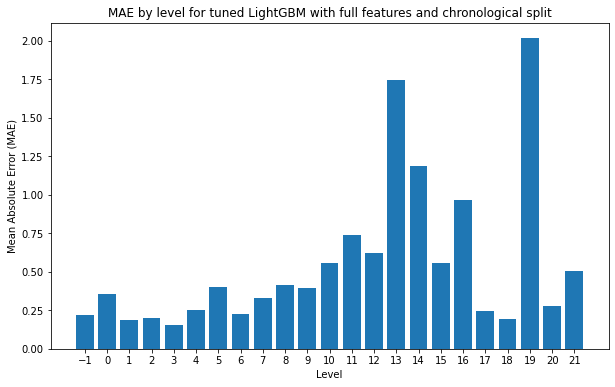

In [64]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with full features and chronological split",
)

In [65]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.45
RMSE: 0.67

Round type: round
MSE: 0.46
RMSE: 0.68

Round type: 0.33
MSE: 0.44
RMSE: 0.66

Round type: 0.45
MSE: 0.48
RMSE: 0.69



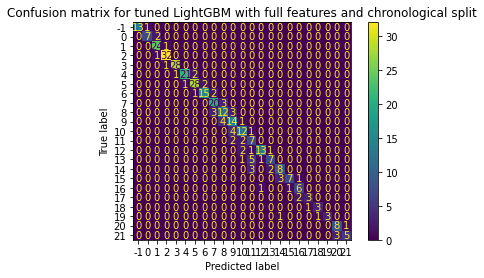

In [66]:
plot_confusion_matrix(
    "round",
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with full features and chronological split",
)

## Random split

In [67]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 48
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	valid_0's l1: 0.246737	valid_0's l2: 0.1379


In [68]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.14
RMSE: 0.37
MAE: 0.25


In [70]:
results.loc[2] = ["random", "default", "full", mse, rmse, mae]

###### MAE by level

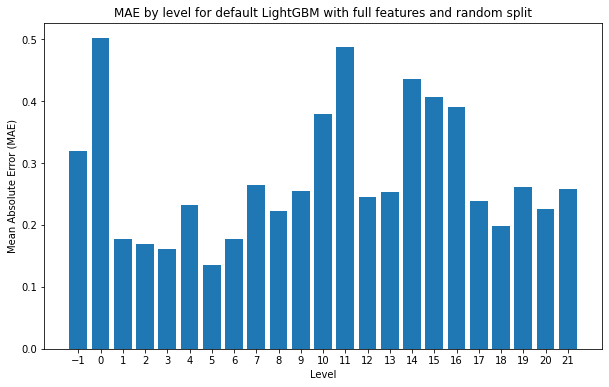

In [71]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with full features and random split",
)

In [72]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 0.14
RMSE: 0.37

Round type: round
MSE: 0.14
RMSE: 0.38

Round type: 0.33
MSE: 0.19
RMSE: 0.43

Round type: 0.45
MSE: 0.15
RMSE: 0.38



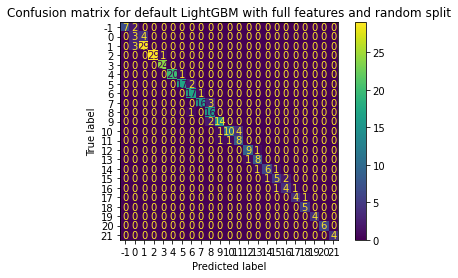

In [73]:
plot_confusion_matrix(
    "round",
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with full features and random split",
)

### Tuning

In [74]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-04 20:01:40,709] A new study created in memory with name: no-name-f4320ea1-bdca-409d-ae52-802e36144a1f

feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.164013 + 0.0448425
[200]	cv_agg's l2: 0.160028 + 0.0430372
[300]	cv_agg's l2: 0.159179 + 0.042371



feature_fraction, val_score: 0.158993:  14%|######4                                      | 1/7 [00:04<00:28,  4.70s/it][I 2023-11-04 20:01:45,417] Trial 0 finished with value: 0.1589932579354761 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.1589932579354761.

feature_fraction, val_score: 0.158993:  14%|######4                                      | 1/7 [00:04<00:28,  4.70s/it]

Early stopping, best iteration is:
[273]	cv_agg's l2: 0.158993 + 0.0423528
[100]	cv_agg's l2: 0.1533 + 0.0197581
[200]	cv_agg's l2: 0.148136 + 0.0211926
[300]	cv_agg's l2: 0.147169 + 0.0210579
[400]	cv_agg's l2: 0.146783 + 0.0211519
[500]	cv_agg's l2: 0.146689 + 0.0215123



feature_fraction, val_score: 0.146647:  29%|############8                                | 2/7 [00:12<00:33,  6.79s/it][I 2023-11-04 20:01:53,678] Trial 1 finished with value: 0.1466470624896303 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.1466470624896303.

feature_fraction, val_score: 0.146647:  29%|############8                                | 2/7 [00:12<00:33,  6.79s/it]

[600]	cv_agg's l2: 0.146709 + 0.0215333
Early stopping, best iteration is:
[508]	cv_agg's l2: 0.146647 + 0.0215112
[100]	cv_agg's l2: 0.176257 + 0.0527383
[200]	cv_agg's l2: 0.172654 + 0.0497109
[300]	cv_agg's l2: 0.171464 + 0.0478321
[400]	cv_agg's l2: 0.170867 + 0.0474651
[500]	cv_agg's l2: 0.170804 + 0.0472238



feature_fraction, val_score: 0.146647:  43%|###################2                         | 3/7 [00:20<00:28,  7.05s/it][I 2023-11-04 20:02:01,036] Trial 2 finished with value: 0.17085701805888892 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.1466470624896303.

feature_fraction, val_score: 0.146647:  43%|###################2                         | 3/7 [00:20<00:28,  7.05s/it]

[600]	cv_agg's l2: 0.170776 + 0.047057
Early stopping, best iteration is:
[508]	cv_agg's l2: 0.146647 + 0.0215112
[100]	cv_agg's l2: 0.172926 + 0.0414372
[200]	cv_agg's l2: 0.168299 + 0.039411
[300]	cv_agg's l2: 0.167189 + 0.0386494
[400]	cv_agg's l2: 0.16679 + 0.0383591
[500]	cv_agg's l2: 0.166595 + 0.0380822


[600]	cv_agg's l2: 0.166676 + 0.0379205
Early stopping, best iteration is:
[508]	cv_agg's l2: 0.146647 + 0.0215112


feature_fraction, val_score: 0.146647:  57%|#########################7                   | 4/7 [00:27<00:21,  7.15s/it][I 2023-11-04 20:02:08,328] Trial 3 finished with value: 0.16656270294388292 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.1466470624896303.

feature_fraction, val_score: 0.146647:  57%|#########################7                   | 4/7 [00:27<00:21,  7.15s/it]

[100]	cv_agg's l2: 0.154973 + 0.0240136
[200]	cv_agg's l2: 0.1486 + 0.0227104
[300]	cv_agg's l2: 0.147421 + 0.0231333
[400]	cv_agg's l2: 0.147061 + 0.0235858
[500]	cv_agg's l2: 0.147068 + 0.0237531



feature_fraction, val_score: 0.146647:  71%|################################1            | 5/7 [00:36<00:15,  7.70s/it][I 2023-11-04 20:02:17,009] Trial 4 finished with value: 0.14704388181946443 and parameters: {'feature_fraction': 0.4}. Best is trial 1 with value: 0.1466470624896303.

feature_fraction, val_score: 0.146647:  71%|################################1            | 5/7 [00:36<00:15,  7.70s/it]

[600]	cv_agg's l2: 0.146906 + 0.0237119
Early stopping, best iteration is:
[508]	cv_agg's l2: 0.146647 + 0.0215112
[100]	cv_agg's l2: 0.171676 + 0.0424751
[200]	cv_agg's l2: 0.167651 + 0.0407129
[300]	cv_agg's l2: 0.166302 + 0.0396484
[400]	cv_agg's l2: 0.165911 + 0.0393818
[500]	cv_agg's l2: 0.166001 + 0.039168



feature_fraction, val_score: 0.146647:  86%|######################################5      | 6/7 [00:40<00:06,  6.57s/it][I 2023-11-04 20:02:21,400] Trial 5 finished with value: 0.16600593503286015 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.1466470624896303.

feature_fraction, val_score: 0.146647:  86%|######################################5      | 6/7 [00:40<00:06,  6.57s/it]

[600]	cv_agg's l2: 0.166048 + 0.0390302
Early stopping, best iteration is:
[508]	cv_agg's l2: 0.146647 + 0.0215112
[100]	cv_agg's l2: 0.164615 + 0.0434878
[200]	cv_agg's l2: 0.161357 + 0.0419626
[300]	cv_agg's l2: 0.160451 + 0.0411068
[400]	cv_agg's l2: 0.159671 + 0.0408473
[500]	cv_agg's l2: 0.159538 + 0.0406135



feature_fraction, val_score: 0.146647: 100%|#############################################| 7/7 [00:44<00:00,  6.41s/it]


[600]	cv_agg's l2: 0.159338 + 0.0402954
Early stopping, best iteration is:
[508]	cv_agg's l2: 0.146647 + 0.0215112



num_leaves, val_score: 0.146647:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.1533 + 0.0197581
[200]	cv_agg's l2: 0.148136 + 0.0211926
[300]	cv_agg's l2: 0.147169 + 0.0210579
[400]	cv_agg's l2: 0.146783 + 0.0211519
[500]	cv_agg's l2: 0.146689 + 0.0215123



num_leaves, val_score: 0.146647:   5%|##5                                               | 1/20 [00:04<01:21,  4.31s/it][I 2023-11-04 20:02:29,915] Trial 7 finished with value: 0.1466470624896303 and parameters: {'num_leaves': 35}. Best is trial 7 with value: 0.1466470624896303.

num_leaves, val_score: 0.146647:   5%|##5                                               | 1/20 [00:04<01:21,  4.31s/it]

[600]	cv_agg's l2: 0.146709 + 0.0215333
Early stopping, best iteration is:
[508]	cv_agg's l2: 0.146647 + 0.0215112
[100]	cv_agg's l2: 0.1533 + 0.0197581
[200]	cv_agg's l2: 0.148136 + 0.0211926
[300]	cv_agg's l2: 0.147169 + 0.0210579
[400]	cv_agg's l2: 0.146783 + 0.0211519
[500]	cv_agg's l2: 0.146689 + 0.0215123



num_leaves, val_score: 0.146647:  10%|#####                                             | 2/20 [00:08<01:17,  4.28s/it][I 2023-11-04 20:02:34,179] Trial 8 finished with value: 0.1466470624896303 and parameters: {'num_leaves': 169}. Best is trial 7 with value: 0.1466470624896303.

num_leaves, val_score: 0.146647:  10%|#####                                             | 2/20 [00:08<01:17,  4.28s/it]

[600]	cv_agg's l2: 0.146709 + 0.0215333
Early stopping, best iteration is:
[508]	cv_agg's l2: 0.146647 + 0.0215112
[100]	cv_agg's l2: 0.152169 + 0.0231284
[200]	cv_agg's l2: 0.146473 + 0.0232458
[300]	cv_agg's l2: 0.14508 + 0.0235328



num_leaves, val_score: 0.144944:  15%|#######5                                          | 3/20 [00:10<00:57,  3.41s/it][I 2023-11-04 20:02:36,545] Trial 9 finished with value: 0.14494407844314267 and parameters: {'num_leaves': 20}. Best is trial 9 with value: 0.14494407844314267.

num_leaves, val_score: 0.144944:  15%|#######5                                          | 3/20 [00:10<00:57,  3.41s/it]

[400]	cv_agg's l2: 0.14508 + 0.0235422
Early stopping, best iteration is:
[330]	cv_agg's l2: 0.144944 + 0.0234618
[100]	cv_agg's l2: 0.167062 + 0.0281494
[200]	cv_agg's l2: 0.155963 + 0.0279704
[300]	cv_agg's l2: 0.150398 + 0.0284524



num_leaves, val_score: 0.144944:  20%|##########                                        | 4/20 [00:12<00:41,  2.59s/it][I 2023-11-04 20:02:37,882] Trial 10 finished with value: 0.15016610192560353 and parameters: {'num_leaves': 7}. Best is trial 9 with value: 0.14494407844314267.

num_leaves, val_score: 0.144944:  20%|##########                                        | 4/20 [00:12<00:41,  2.59s/it]

[400]	cv_agg's l2: 0.146601 + 0.0288062
Early stopping, best iteration is:
[330]	cv_agg's l2: 0.144944 + 0.0234618
[100]	cv_agg's l2: 0.1533 + 0.0197581
[200]	cv_agg's l2: 0.148136 + 0.0211926
[300]	cv_agg's l2: 0.147169 + 0.0210579


[400]	cv_agg's l2: 0.146783 + 0.0211519
Early stopping, best iteration is:
[330]	cv_agg's l2: 0.144944 + 0.0234618


num_leaves, val_score: 0.144944:  25%|############5                                     | 5/20 [00:15<00:41,  2.74s/it][I 2023-11-04 20:02:40,882] Trial 11 finished with value: 0.14704131368661374 and parameters: {'num_leaves': 96}. Best is trial 9 with value: 0.14494407844314267.

num_leaves, val_score: 0.144944:  25%|############5                                     | 5/20 [00:15<00:41,  2.74s/it]

[100]	cv_agg's l2: 0.1533 + 0.0197581
[200]	cv_agg's l2: 0.148136 + 0.0211926
[300]	cv_agg's l2: 0.147169 + 0.0210579
[400]	cv_agg's l2: 0.146783 + 0.0211519



num_leaves, val_score: 0.144944:  30%|###############                                   | 6/20 [00:19<00:43,  3.09s/it][I 2023-11-04 20:02:44,654] Trial 12 finished with value: 0.14704131368661374 and parameters: {'num_leaves': 251}. Best is trial 9 with value: 0.14494407844314267.

num_leaves, val_score: 0.144944:  30%|###############                                   | 6/20 [00:19<00:43,  3.09s/it]

Early stopping, best iteration is:
[330]	cv_agg's l2: 0.144944 + 0.0234618
[100]	cv_agg's l2: 0.1533 + 0.0197581
[200]	cv_agg's l2: 0.148136 + 0.0211926
[300]	cv_agg's l2: 0.147169 + 0.0210579
[400]	cv_agg's l2: 0.146783 + 0.0211519



num_leaves, val_score: 0.144944:  35%|#################5                                | 7/20 [00:22<00:40,  3.11s/it][I 2023-11-04 20:02:47,803] Trial 13 finished with value: 0.14704131368661374 and parameters: {'num_leaves': 94}. Best is trial 9 with value: 0.14494407844314267.

num_leaves, val_score: 0.144944:  35%|#################5                                | 7/20 [00:22<00:40,  3.11s/it]

Early stopping, best iteration is:
[330]	cv_agg's l2: 0.144944 + 0.0234618
[100]	cv_agg's l2: 0.1533 + 0.0197581
[200]	cv_agg's l2: 0.148136 + 0.0211926
[300]	cv_agg's l2: 0.147169 + 0.0210579
[400]	cv_agg's l2: 0.146783 + 0.0211519
Early stopping, best iteration is:
[330]	cv_agg's l2: 0.144944 + 0.0234618



num_leaves, val_score: 0.144944:  40%|####################                              | 8/20 [00:25<00:37,  3.10s/it][I 2023-11-04 20:02:50,896] Trial 14 finished with value: 0.14704131368661374 and parameters: {'num_leaves': 171}. Best is trial 9 with value: 0.14494407844314267.

num_leaves, val_score: 0.144944:  40%|####################                              | 8/20 [00:25<00:37,  3.10s/it]

[100]	cv_agg's l2: 0.1533 + 0.0197581
[200]	cv_agg's l2: 0.148136 + 0.0211926
[300]	cv_agg's l2: 0.147169 + 0.0210579
[400]	cv_agg's l2: 0.146783 + 0.0211519



num_leaves, val_score: 0.144944:  45%|######################5                           | 9/20 [00:28<00:34,  3.14s/it][I 2023-11-04 20:02:54,112] Trial 15 finished with value: 0.14704131368661374 and parameters: {'num_leaves': 49}. Best is trial 9 with value: 0.14494407844314267.

num_leaves, val_score: 0.144944:  45%|######################5                           | 9/20 [00:28<00:34,  3.14s/it]

Early stopping, best iteration is:
[330]	cv_agg's l2: 0.144944 + 0.0234618
[100]	cv_agg's l2: 0.1533 + 0.0197581
[200]	cv_agg's l2: 0.148136 + 0.0211926
[300]	cv_agg's l2: 0.147169 + 0.0210579
[400]	cv_agg's l2: 0.146783 + 0.0211519
Early stopping, best iteration is:
[330]	cv_agg's l2: 0.144944 + 0.0234618



num_leaves, val_score: 0.144944:  50%|########################5                        | 10/20 [00:31<00:31,  3.14s/it][I 2023-11-04 20:02:57,266] Trial 16 finished with value: 0.14704131368661374 and parameters: {'num_leaves': 242}. Best is trial 9 with value: 0.14494407844314267.

num_leaves, val_score: 0.144944:  50%|########################5                        | 10/20 [00:31<00:31,  3.14s/it]

[100]	cv_agg's l2: 0.1533 + 0.0197581
[200]	cv_agg's l2: 0.148136 + 0.0211926
[300]	cv_agg's l2: 0.147169 + 0.0210579
[400]	cv_agg's l2: 0.146783 + 0.0211519



num_leaves, val_score: 0.144944:  55%|##########################9                      | 11/20 [00:34<00:27,  3.02s/it][I 2023-11-04 20:02:59,996] Trial 17 finished with value: 0.14704131368661374 and parameters: {'num_leaves': 79}. Best is trial 9 with value: 0.14494407844314267.

num_leaves, val_score: 0.144944:  55%|##########################9                      | 11/20 [00:34<00:27,  3.02s/it]

Early stopping, best iteration is:
[330]	cv_agg's l2: 0.144944 + 0.0234618
[100]	cv_agg's l2: 0.1533 + 0.0197581
[200]	cv_agg's l2: 0.148136 + 0.0211926
[300]	cv_agg's l2: 0.147169 + 0.0210579
[400]	cv_agg's l2: 0.146783 + 0.0211519
Early stopping, best iteration is:
[330]	cv_agg's l2: 0.144944 + 0.0234618



num_leaves, val_score: 0.144944:  60%|#############################4                   | 12/20 [00:37<00:23,  2.98s/it][I 2023-11-04 20:03:02,875] Trial 18 finished with value: 0.14704131368661374 and parameters: {'num_leaves': 144}. Best is trial 9 with value: 0.14494407844314267.

num_leaves, val_score: 0.144944:  60%|#############################4                   | 12/20 [00:37<00:23,  2.98s/it]

[100]	cv_agg's l2: 0.1533 + 0.0197581
[200]	cv_agg's l2: 0.148136 + 0.0211926
[300]	cv_agg's l2: 0.147169 + 0.0210579


[400]	cv_agg's l2: 0.146783 + 0.0211519
Early stopping, best iteration is:
[330]	cv_agg's l2: 0.144944 + 0.0234618


num_leaves, val_score: 0.144944:  65%|###############################8                 | 13/20 [00:40<00:20,  2.91s/it][I 2023-11-04 20:03:05,652] Trial 19 finished with value: 0.14704131368661374 and parameters: {'num_leaves': 199}. Best is trial 9 with value: 0.14494407844314267.

num_leaves, val_score: 0.144944:  65%|###############################8                 | 13/20 [00:40<00:20,  2.91s/it]

[100]	cv_agg's l2: 0.257946 + 0.038326
[200]	cv_agg's l2: 0.227332 + 0.0378141
[300]	cv_agg's l2: 0.211825 + 0.0378876



num_leaves, val_score: 0.144944:  70%|##################################3              | 14/20 [00:40<00:13,  2.31s/it][I 2023-11-04 20:03:06,552] Trial 20 finished with value: 0.2083551486243856 and parameters: {'num_leaves': 3}. Best is trial 9 with value: 0.14494407844314267.

num_leaves, val_score: 0.144944:  70%|##################################3              | 14/20 [00:40<00:13,  2.31s/it]

[400]	cv_agg's l2: 0.201881 + 0.034592
Early stopping, best iteration is:
[330]	cv_agg's l2: 0.144944 + 0.0234618
[100]	cv_agg's l2: 0.1533 + 0.0197581
[200]	cv_agg's l2: 0.148136 + 0.0211926
[300]	cv_agg's l2: 0.147169 + 0.0210579


[400]	cv_agg's l2: 0.146783 + 0.0211519
Early stopping, best iteration is:
[330]	cv_agg's l2: 0.144944 + 0.0234618


num_leaves, val_score: 0.144944:  75%|####################################7            | 15/20 [00:43<00:12,  2.45s/it][I 2023-11-04 20:03:09,329] Trial 21 finished with value: 0.14704131368661374 and parameters: {'num_leaves': 42}. Best is trial 9 with value: 0.14494407844314267.

num_leaves, val_score: 0.144944:  75%|####################################7            | 15/20 [00:43<00:12,  2.45s/it]

[100]	cv_agg's l2: 0.1533 + 0.0197581
[200]	cv_agg's l2: 0.148136 + 0.0211926
[300]	cv_agg's l2: 0.147169 + 0.0210579


[400]	cv_agg's l2: 0.146783 + 0.0211519
Early stopping, best iteration is:
[330]	cv_agg's l2: 0.144944 + 0.0234618


num_leaves, val_score: 0.144944:  80%|#######################################2         | 16/20 [00:46<00:10,  2.55s/it][I 2023-11-04 20:03:12,113] Trial 22 finished with value: 0.14704131368661374 and parameters: {'num_leaves': 48}. Best is trial 9 with value: 0.14494407844314267.

num_leaves, val_score: 0.144944:  80%|#######################################2         | 16/20 [00:46<00:10,  2.55s/it]

[100]	cv_agg's l2: 0.151962 + 0.0216839
[200]	cv_agg's l2: 0.147146 + 0.0207155
[300]	cv_agg's l2: 0.145303 + 0.0210843
[400]	cv_agg's l2: 0.14479 + 0.0209565
[500]	cv_agg's l2: 0.144478 + 0.0208958
[600]	cv_agg's l2: 0.144402 + 0.0207775
[700]	cv_agg's l2: 0.144258 + 0.0206654



num_leaves, val_score: 0.144213:  85%|#########################################6       | 17/20 [00:52<00:10,  3.47s/it][I 2023-11-04 20:03:17,722] Trial 23 finished with value: 0.14421288069526633 and parameters: {'num_leaves': 28}. Best is trial 23 with value: 0.14421288069526633.

num_leaves, val_score: 0.144213:  85%|#########################################6       | 17/20 [00:52<00:10,  3.47s/it]

[800]	cv_agg's l2: 0.144268 + 0.0205977
Early stopping, best iteration is:
[726]	cv_agg's l2: 0.144213 + 0.0206065


[100]	cv_agg's l2: 0.1533 + 0.0197581
[200]	cv_agg's l2: 0.148136 + 0.0211926
[300]	cv_agg's l2: 0.147169 + 0.0210579
[400]	cv_agg's l2: 0.146783 + 0.0211519
[500]	cv_agg's l2: 0.146689 + 0.0215123
[600]	cv_agg's l2: 0.146709 + 0.0215333
[700]	cv_agg's l2: 0.14675 + 0.0216376



num_leaves, val_score: 0.144213:  90%|############################################1    | 18/20 [00:57<00:08,  4.04s/it]

[800]	cv_agg's l2: 0.146755 + 0.0216102
Early stopping, best iteration is:
[726]	cv_agg's l2: 0.144213 + 0.0206065


[I 2023-11-04 20:03:23,087] Trial 24 finished with value: 0.14671858003534868 and parameters: {'num_leaves': 71}. Best is trial 23 with value: 0.14421288069526633.

num_leaves, val_score: 0.144213:  90%|############################################1    | 18/20 [00:57<00:08,  4.04s/it]

[100]	cv_agg's l2: 0.1533 + 0.0197581
[200]	cv_agg's l2: 0.148136 + 0.0211926
[300]	cv_agg's l2: 0.147169 + 0.0210579
[400]	cv_agg's l2: 0.146783 + 0.0211519
[500]	cv_agg's l2: 0.146689 + 0.0215123
[600]	cv_agg's l2: 0.146709 + 0.0215333
[700]	cv_agg's l2: 0.14675 + 0.0216376


[800]	cv_agg's l2: 0.146755 + 0.0216102
Early stopping, best iteration is:
[726]	cv_agg's l2: 0.144213 + 0.0206065


num_leaves, val_score: 0.144213:  95%|##############################################5  | 19/20 [01:03<00:04,  4.49s/it][I 2023-11-04 20:03:28,627] Trial 25 finished with value: 0.14671858003534868 and parameters: {'num_leaves': 121}. Best is trial 23 with value: 0.14421288069526633.

num_leaves, val_score: 0.144213:  95%|##############################################5  | 19/20 [01:03<00:04,  4.49s/it]

[100]	cv_agg's l2: 0.150369 + 0.0228694
[200]	cv_agg's l2: 0.144114 + 0.0210669
[300]	cv_agg's l2: 0.143121 + 0.0211473
[400]	cv_agg's l2: 0.142633 + 0.0212951
[500]	cv_agg's l2: 0.142585 + 0.0212789



num_leaves, val_score: 0.142562: 100%|#################################################| 20/20 [01:06<00:00,  3.30s/it]


Early stopping, best iteration is:
[499]	cv_agg's l2: 0.142562 + 0.0212672



bagging, val_score: 0.142562:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.163791 + 0.0286387
[200]	cv_agg's l2: 0.154514 + 0.0269879
[300]	cv_agg's l2: 0.15293 + 0.0277047
[400]	cv_agg's l2: 0.151687 + 0.0280142
[500]	cv_agg's l2: 0.150843 + 0.0279817



bagging, val_score: 0.142562:  10%|#####3                                               | 1/10 [00:03<00:27,  3.00s/it][I 2023-11-04 20:03:34,663] Trial 27 finished with value: 0.1508985114081749 and parameters: {'bagging_fraction': 0.7821483085003584, 'bagging_freq': 5}. Best is trial 27 with value: 0.1508985114081749.

bagging, val_score: 0.142562:  10%|#####3                                               | 1/10 [00:03<00:27,  3.00s/it]

Early stopping, best iteration is:
[499]	cv_agg's l2: 0.142562 + 0.0212672
[100]	cv_agg's l2: 0.197984 + 0.0231448
[200]	cv_agg's l2: 0.186161 + 0.0277917
[300]	cv_agg's l2: 0.183849 + 0.0253616
[400]	cv_agg's l2: 0.183 + 0.0226489
[500]	cv_agg's l2: 0.182537 + 0.0212185



bagging, val_score: 0.142562:  20%|##########6                                          | 2/10 [00:05<00:20,  2.59s/it][I 2023-11-04 20:03:36,959] Trial 28 finished with value: 0.18235062799330679 and parameters: {'bagging_fraction': 0.4172872927497454, 'bagging_freq': 1}. Best is trial 27 with value: 0.1508985114081749.

bagging, val_score: 0.142562:  20%|##########6                                          | 2/10 [00:05<00:20,  2.59s/it]

Early stopping, best iteration is:
[499]	cv_agg's l2: 0.142562 + 0.0212672
[100]	cv_agg's l2: 0.150369 + 0.0228694
[200]	cv_agg's l2: 0.144114 + 0.0210669
[300]	cv_agg's l2: 0.143121 + 0.0211473
[400]	cv_agg's l2: 0.142633 + 0.0212951
[500]	cv_agg's l2: 0.142585 + 0.0212789



bagging, val_score: 0.142562:  30%|###############9                                     | 3/10 [00:08<00:19,  2.82s/it][I 2023-11-04 20:03:40,062] Trial 29 finished with value: 0.14256163980545236 and parameters: {'bagging_fraction': 0.9990044673930644, 'bagging_freq': 7}. Best is trial 29 with value: 0.14256163980545236.

bagging, val_score: 0.142562:  30%|###############9                                     | 3/10 [00:08<00:19,  2.82s/it]

Early stopping, best iteration is:
[499]	cv_agg's l2: 0.142562 + 0.0212672
[100]	cv_agg's l2: 0.155074 + 0.0302297
[200]	cv_agg's l2: 0.148095 + 0.0283102
[300]	cv_agg's l2: 0.146269 + 0.0283519
[400]	cv_agg's l2: 0.145867 + 0.0285756
[500]	cv_agg's l2: 0.145996 + 0.0286842



bagging, val_score: 0.142562:  40%|#####################2                               | 4/10 [00:11<00:17,  2.96s/it][I 2023-11-04 20:03:43,242] Trial 30 finished with value: 0.14598572905410878 and parameters: {'bagging_fraction': 0.9757683353386049, 'bagging_freq': 7}. Best is trial 29 with value: 0.14256163980545236.

bagging, val_score: 0.142562:  40%|#####################2                               | 4/10 [00:11<00:17,  2.96s/it]

Early stopping, best iteration is:
[499]	cv_agg's l2: 0.142562 + 0.0212672
[100]	cv_agg's l2: 0.150369 + 0.0228694
[200]	cv_agg's l2: 0.144114 + 0.0210669
[300]	cv_agg's l2: 0.143121 + 0.0211473
[400]	cv_agg's l2: 0.142633 + 0.0212951
[500]	cv_agg's l2: 0.142585 + 0.0212789



bagging, val_score: 0.142562:  50%|##########################5                          | 5/10 [00:14<00:15,  3.01s/it][I 2023-11-04 20:03:46,324] Trial 31 finished with value: 0.14256163980545236 and parameters: {'bagging_fraction': 0.9985621716727551, 'bagging_freq': 7}. Best is trial 29 with value: 0.14256163980545236.

bagging, val_score: 0.142562:  50%|##########################5                          | 5/10 [00:14<00:15,  3.01s/it]

Early stopping, best iteration is:
[499]	cv_agg's l2: 0.142562 + 0.0212672
[100]	cv_agg's l2: 0.152362 + 0.0241867
[200]	cv_agg's l2: 0.146829 + 0.0237133
[300]	cv_agg's l2: 0.14588 + 0.0234627
[400]	cv_agg's l2: 0.144602 + 0.0230211
[500]	cv_agg's l2: 0.144401 + 0.0230125



bagging, val_score: 0.142562:  60%|###############################8                     | 6/10 [00:17<00:12,  3.10s/it][I 2023-11-04 20:03:49,601] Trial 32 finished with value: 0.14440618706202435 and parameters: {'bagging_fraction': 0.9958610439834464, 'bagging_freq': 7}. Best is trial 29 with value: 0.14256163980545236.

bagging, val_score: 0.142562:  60%|###############################8                     | 6/10 [00:17<00:12,  3.10s/it]

Early stopping, best iteration is:
[499]	cv_agg's l2: 0.142562 + 0.0212672
[100]	cv_agg's l2: 0.159517 + 0.0314512
[200]	cv_agg's l2: 0.154118 + 0.0311729
[300]	cv_agg's l2: 0.152187 + 0.0301805
[400]	cv_agg's l2: 0.151158 + 0.029894
[500]	cv_agg's l2: 0.150937 + 0.0298418



bagging, val_score: 0.142562:  70%|#####################################                | 7/10 [00:21<00:09,  3.26s/it][I 2023-11-04 20:03:53,202] Trial 33 finished with value: 0.1509505997118039 and parameters: {'bagging_fraction': 0.9706752265231755, 'bagging_freq': 5}. Best is trial 29 with value: 0.14256163980545236.

bagging, val_score: 0.142562:  70%|#####################################                | 7/10 [00:21<00:09,  3.26s/it]

Early stopping, best iteration is:
[499]	cv_agg's l2: 0.142562 + 0.0212672
[100]	cv_agg's l2: 0.154269 + 0.0346311
[200]	cv_agg's l2: 0.147788 + 0.0332283
[300]	cv_agg's l2: 0.144478 + 0.0325316
[400]	cv_agg's l2: 0.144156 + 0.032191
[500]	cv_agg's l2: 0.144069 + 0.0322028



bagging, val_score: 0.142562:  80%|##########################################4          | 8/10 [00:24<00:06,  3.27s/it][I 2023-11-04 20:03:56,486] Trial 34 finished with value: 0.14406642291532806 and parameters: {'bagging_fraction': 0.8168803049308622, 'bagging_freq': 7}. Best is trial 29 with value: 0.14256163980545236.

bagging, val_score: 0.142562:  80%|##########################################4          | 8/10 [00:24<00:06,  3.27s/it]

Early stopping, best iteration is:
[499]	cv_agg's l2: 0.142562 + 0.0212672
[100]	cv_agg's l2: 0.155707 + 0.0305903
[200]	cv_agg's l2: 0.147287 + 0.0300886
[300]	cv_agg's l2: 0.144598 + 0.0292924
[400]	cv_agg's l2: 0.143155 + 0.0287825
[500]	cv_agg's l2: 0.143412 + 0.0287851



bagging, val_score: 0.142562:  90%|###############################################7     | 9/10 [00:27<00:03,  3.22s/it][I 2023-11-04 20:03:59,608] Trial 35 finished with value: 0.14343186467927063 and parameters: {'bagging_fraction': 0.8462602647811204, 'bagging_freq': 7}. Best is trial 29 with value: 0.14256163980545236.

bagging, val_score: 0.142562:  90%|###############################################7     | 9/10 [00:27<00:03,  3.22s/it]

Early stopping, best iteration is:
[499]	cv_agg's l2: 0.142562 + 0.0212672
[100]	cv_agg's l2: 0.151599 + 0.0273688
[200]	cv_agg's l2: 0.142956 + 0.0237914
[300]	cv_agg's l2: 0.140903 + 0.0244767
[400]	cv_agg's l2: 0.140433 + 0.0240128



bagging, val_score: 0.140266: 100%|####################################################| 10/10 [00:30<00:00,  3.06s/it]


Early stopping, best iteration is:
[378]	cv_agg's l2: 0.140266 + 0.0242047



feature_fraction_stage2, val_score: 0.140266:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.153863 + 0.0245205
[200]	cv_agg's l2: 0.144436 + 0.0233708
[300]	cv_agg's l2: 0.143465 + 0.0236693
[400]	cv_agg's l2: 0.141902 + 0.0230085



feature_fraction_stage2, val_score: 0.140266:  17%|######3                               | 1/6 [00:02<00:12,  2.44s/it][I 2023-11-04 20:04:04,705] Trial 37 finished with value: 0.14185515130132706 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 37 with value: 0.14185515130132706.

feature_fraction_stage2, val_score: 0.140266:  17%|######3                               | 1/6 [00:02<00:12,  2.44s/it]

Early stopping, best iteration is:
[378]	cv_agg's l2: 0.140266 + 0.0242047
[100]	cv_agg's l2: 0.154154 + 0.0363199
[200]	cv_agg's l2: 0.146384 + 0.03238
[300]	cv_agg's l2: 0.144297 + 0.0320718
[400]	cv_agg's l2: 0.144038 + 0.031471



feature_fraction_stage2, val_score: 0.140266:  33%|############6                         | 2/6 [00:04<00:09,  2.49s/it][I 2023-11-04 20:04:07,235] Trial 38 finished with value: 0.14375946018719638 and parameters: {'feature_fraction': 0.58}. Best is trial 37 with value: 0.14185515130132706.

feature_fraction_stage2, val_score: 0.140266:  33%|############6                         | 2/6 [00:04<00:09,  2.49s/it]

Early stopping, best iteration is:
[378]	cv_agg's l2: 0.140266 + 0.0242047
[100]	cv_agg's l2: 0.148911 + 0.0269861
[200]	cv_agg's l2: 0.142424 + 0.0271748
[300]	cv_agg's l2: 0.140139 + 0.0276803
[400]	cv_agg's l2: 0.139395 + 0.0274587
[500]	cv_agg's l2: 0.139297 + 0.0272652



feature_fraction_stage2, val_score: 0.139170:  50%|###################                   | 3/6 [00:08<00:09,  3.04s/it][I 2023-11-04 20:04:10,926] Trial 39 finished with value: 0.13917047675167823 and parameters: {'feature_fraction': 0.516}. Best is trial 39 with value: 0.13917047675167823.

feature_fraction_stage2, val_score: 0.139170:  50%|###################                   | 3/6 [00:08<00:09,  3.04s/it]

Early stopping, best iteration is:
[425]	cv_agg's l2: 0.13917 + 0.0273284
[100]	cv_agg's l2: 0.153697 + 0.0275462
[200]	cv_agg's l2: 0.146582 + 0.0268823
[300]	cv_agg's l2: 0.145197 + 0.0276986
[400]	cv_agg's l2: 0.144616 + 0.0278585



feature_fraction_stage2, val_score: 0.139170:  67%|#########################3            | 4/6 [00:13<00:07,  3.68s/it][I 2023-11-04 20:04:15,584] Trial 40 finished with value: 0.14440241669173695 and parameters: {'feature_fraction': 0.484}. Best is trial 39 with value: 0.13917047675167823.

feature_fraction_stage2, val_score: 0.139170:  67%|#########################3            | 4/6 [00:13<00:07,  3.68s/it]

[500]	cv_agg's l2: 0.144311 + 0.027349
Early stopping, best iteration is:
[425]	cv_agg's l2: 0.13917 + 0.0273284
[100]	cv_agg's l2: 0.151527 + 0.0300993
[200]	cv_agg's l2: 0.142478 + 0.0277456
[300]	cv_agg's l2: 0.140707 + 0.0277398
[400]	cv_agg's l2: 0.139921 + 0.0272444



feature_fraction_stage2, val_score: 0.139170:  83%|###############################6      | 5/6 [00:16<00:03,  3.50s/it][I 2023-11-04 20:04:18,766] Trial 41 finished with value: 0.13998106918361566 and parameters: {'feature_fraction': 0.5479999999999999}. Best is trial 39 with value: 0.13917047675167823.

feature_fraction_stage2, val_score: 0.139170:  83%|###############################6      | 5/6 [00:16<00:03,  3.50s/it]

[500]	cv_agg's l2: 0.139796 + 0.0268945
Early stopping, best iteration is:
[425]	cv_agg's l2: 0.13917 + 0.0273284
[100]	cv_agg's l2: 0.15746 + 0.0261257
[200]	cv_agg's l2: 0.147091 + 0.0246784
[300]	cv_agg's l2: 0.144241 + 0.0237624
[400]	cv_agg's l2: 0.143663 + 0.0238273



feature_fraction_stage2, val_score: 0.139170: 100%|######################################| 6/6 [00:19<00:00,  3.24s/it]


[500]	cv_agg's l2: 0.143679 + 0.0238546
Early stopping, best iteration is:
[425]	cv_agg's l2: 0.13917 + 0.0273284



regularization_factors, val_score: 0.139170:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.152341 + 0.0301336
[200]	cv_agg's l2: 0.144047 + 0.0298589
[300]	cv_agg's l2: 0.142011 + 0.0297047
[400]	cv_agg's l2: 0.141664 + 0.0297946



regularization_factors, val_score: 0.139170:   5%|#9                                    | 1/20 [00:02<00:50,  2.66s/it][I 2023-11-04 20:04:24,398] Trial 43 finished with value: 0.1415577913551867 and parameters: {'lambda_l1': 0.6961631341509237, 'lambda_l2': 0.003813076130866319}. Best is trial 43 with value: 0.1415577913551867.

regularization_factors, val_score: 0.139170:   5%|#9                                    | 1/20 [00:02<00:50,  2.66s/it]

[500]	cv_agg's l2: 0.141399 + 0.0296814
Early stopping, best iteration is:
[425]	cv_agg's l2: 0.13917 + 0.0273284
[100]	cv_agg's l2: 0.162679 + 0.0375666
[200]	cv_agg's l2: 0.153414 + 0.0346327
[300]	cv_agg's l2: 0.15003 + 0.0340532
[400]	cv_agg's l2: 0.14927 + 0.033173
[500]	cv_agg's l2: 0.148973 + 0.0333027



regularization_factors, val_score: 0.139170:  10%|###8                                  | 2/20 [00:04<00:37,  2.08s/it][I 2023-11-04 20:04:26,082] Trial 44 finished with value: 0.14919877381725183 and parameters: {'lambda_l1': 2.193325089870511, 'lambda_l2': 0.003914321415109026}. Best is trial 43 with value: 0.1415577913551867.

regularization_factors, val_score: 0.139170:  10%|###8                                  | 2/20 [00:04<00:37,  2.08s/it]

Early stopping, best iteration is:
[425]	cv_agg's l2: 0.13917 + 0.0273284
[100]	cv_agg's l2: 0.151402 + 0.0282183
[200]	cv_agg's l2: 0.14507 + 0.0247966
[300]	cv_agg's l2: 0.142399 + 0.0249084
[400]	cv_agg's l2: 0.141474 + 0.0241715



regularization_factors, val_score: 0.139170:  15%|#####7                                | 3/20 [00:07<00:41,  2.46s/it][I 2023-11-04 20:04:28,982] Trial 45 finished with value: 0.1412864419180985 and parameters: {'lambda_l1': 0.008723921501801417, 'lambda_l2': 1.1912809757213113e-06}. Best is trial 45 with value: 0.1412864419180985.

regularization_factors, val_score: 0.139170:  15%|#####7                                | 3/20 [00:07<00:41,  2.46s/it]

[500]	cv_agg's l2: 0.140848 + 0.0243323
Early stopping, best iteration is:
[425]	cv_agg's l2: 0.13917 + 0.0273284
[100]	cv_agg's l2: 0.14876 + 0.0307716
[200]	cv_agg's l2: 0.140125 + 0.0276186
[300]	cv_agg's l2: 0.138193 + 0.0267727
[400]	cv_agg's l2: 0.137557 + 0.0256672



regularization_factors, val_score: 0.137315:  20%|#######6                              | 4/20 [00:09<00:39,  2.46s/it][I 2023-11-04 20:04:31,447] Trial 46 finished with value: 0.1373149332511003 and parameters: {'lambda_l1': 0.022221310569250263, 'lambda_l2': 2.1560400451503022e-07}. Best is trial 46 with value: 0.1373149332511003.

regularization_factors, val_score: 0.137315:  20%|#######6                              | 4/20 [00:09<00:39,  2.46s/it]

Early stopping, best iteration is:
[341]	cv_agg's l2: 0.137315 + 0.0263385
[100]	cv_agg's l2: 0.148868 + 0.0269848
[200]	cv_agg's l2: 0.143365 + 0.0265847
[300]	cv_agg's l2: 0.140568 + 0.0270913
[400]	cv_agg's l2: 0.139739 + 0.026832
Early stopping, best iteration is:
[341]	cv_agg's l2: 0.137315 + 0.0263385



regularization_factors, val_score: 0.137315:  25%|#########5                            | 5/20 [00:12<00:36,  2.42s/it][I 2023-11-04 20:04:33,791] Trial 47 finished with value: 0.1401798257911408 and parameters: {'lambda_l1': 0.00015179384656274889, 'lambda_l2': 1.8347386540812305e-08}. Best is trial 46 with value: 0.1373149332511003.

regularization_factors, val_score: 0.137315:  25%|#########5                            | 5/20 [00:12<00:36,  2.42s/it]

[100]	cv_agg's l2: 0.148911 + 0.0269861
[200]	cv_agg's l2: 0.142477 + 0.0271371
[300]	cv_agg's l2: 0.140244 + 0.0276181
[400]	cv_agg's l2: 0.139443 + 0.0274309



regularization_factors, val_score: 0.137315:  30%|###########4                          | 6/20 [00:14<00:34,  2.45s/it][I 2023-11-04 20:04:36,298] Trial 48 finished with value: 0.13951846780583307 and parameters: {'lambda_l1': 7.777990246334234e-06, 'lambda_l2': 1.3806441453244392e-08}. Best is trial 46 with value: 0.1373149332511003.

regularization_factors, val_score: 0.137315:  30%|###########4                          | 6/20 [00:14<00:34,  2.45s/it]

Early stopping, best iteration is:
[341]	cv_agg's l2: 0.137315 + 0.0263385
[100]	cv_agg's l2: 0.148911 + 0.0269861
[200]	cv_agg's l2: 0.142477 + 0.0271371
[300]	cv_agg's l2: 0.140244 + 0.0276181
[400]	cv_agg's l2: 0.139443 + 0.0274309



regularization_factors, val_score: 0.137315:  35%|#############3                        | 7/20 [00:17<00:35,  2.72s/it][I 2023-11-04 20:04:39,574] Trial 49 finished with value: 0.13951846235086823 and parameters: {'lambda_l1': 4.405318381415831e-06, 'lambda_l2': 1.4529144674893563e-08}. Best is trial 46 with value: 0.1373149332511003.

regularization_factors, val_score: 0.137315:  35%|#############3                        | 7/20 [00:17<00:35,  2.72s/it]

Early stopping, best iteration is:
[341]	cv_agg's l2: 0.137315 + 0.0263385
[100]	cv_agg's l2: 0.148911 + 0.0269861
[200]	cv_agg's l2: 0.142424 + 0.0271748
[300]	cv_agg's l2: 0.140139 + 0.0276803
[400]	cv_agg's l2: 0.139395 + 0.0274587



regularization_factors, val_score: 0.137315:  40%|###############2                      | 8/20 [00:20<00:33,  2.81s/it][I 2023-11-04 20:04:42,571] Trial 50 finished with value: 0.13943742202567871 and parameters: {'lambda_l1': 2.960744407886877e-07, 'lambda_l2': 1.4011017620647313e-08}. Best is trial 46 with value: 0.1373149332511003.

regularization_factors, val_score: 0.137315:  40%|###############2                      | 8/20 [00:20<00:33,  2.81s/it]

Early stopping, best iteration is:
[341]	cv_agg's l2: 0.137315 + 0.0263385
[100]	cv_agg's l2: 0.148911 + 0.0269861
[200]	cv_agg's l2: 0.142424 + 0.0271748
[300]	cv_agg's l2: 0.140139 + 0.0276803
[400]	cv_agg's l2: 0.139395 + 0.0274587
Early stopping, best iteration is:
[341]	cv_agg's l2: 0.137315 + 0.0263385



regularization_factors, val_score: 0.137315:  45%|#################1                    | 9/20 [00:23<00:31,  2.90s/it][I 2023-11-04 20:04:45,691] Trial 51 finished with value: 0.13943742199519668 and parameters: {'lambda_l1': 2.8227894527024093e-07, 'lambda_l2': 2.0339695894252285e-08}. Best is trial 46 with value: 0.1373149332511003.

regularization_factors, val_score: 0.137315:  45%|#################1                    | 9/20 [00:23<00:31,  2.90s/it]

[100]	cv_agg's l2: 0.148911 + 0.0269861
[200]	cv_agg's l2: 0.142424 + 0.0271748
[300]	cv_agg's l2: 0.140139 + 0.0276803
[400]	cv_agg's l2: 0.139395 + 0.0274587



regularization_factors, val_score: 0.137315:  50%|##################5                  | 10/20 [00:26<00:29,  2.91s/it][I 2023-11-04 20:04:48,614] Trial 52 finished with value: 0.13943742177284807 and parameters: {'lambda_l1': 2.113791476079673e-07, 'lambda_l2': 5.498241964337862e-08}. Best is trial 46 with value: 0.1373149332511003.

regularization_factors, val_score: 0.137315:  50%|##################5                  | 10/20 [00:26<00:29,  2.91s/it]

Early stopping, best iteration is:
[341]	cv_agg's l2: 0.137315 + 0.0263385
[100]	cv_agg's l2: 0.148911 + 0.0269861
[200]	cv_agg's l2: 0.142424 + 0.0271748
[300]	cv_agg's l2: 0.140139 + 0.0276803
[400]	cv_agg's l2: 0.139395 + 0.0274587



regularization_factors, val_score: 0.137315:  55%|####################3                | 11/20 [00:30<00:27,  3.06s/it][I 2023-11-04 20:04:52,017] Trial 53 finished with value: 0.1394374217456744 and parameters: {'lambda_l1': 9.72974234009977e-08, 'lambda_l2': 1.7706001500335913e-08}. Best is trial 46 with value: 0.1373149332511003.

regularization_factors, val_score: 0.137315:  55%|####################3                | 11/20 [00:30<00:27,  3.06s/it]

Early stopping, best iteration is:
[341]	cv_agg's l2: 0.137315 + 0.0263385
[100]	cv_agg's l2: 0.148911 + 0.0269861
[200]	cv_agg's l2: 0.142424 + 0.0271748
[300]	cv_agg's l2: 0.140139 + 0.0276803
[400]	cv_agg's l2: 0.139395 + 0.0274587



regularization_factors, val_score: 0.137315:  60%|######################2              | 12/20 [00:32<00:23,  2.93s/it][I 2023-11-04 20:04:54,649] Trial 54 finished with value: 0.13943742115395122 and parameters: {'lambda_l1': 3.955949767992286e-08, 'lambda_l2': 2.2051873589581734e-07}. Best is trial 46 with value: 0.1373149332511003.

regularization_factors, val_score: 0.137315:  60%|######################2              | 12/20 [00:32<00:23,  2.93s/it]

Early stopping, best iteration is:
[341]	cv_agg's l2: 0.137315 + 0.0263385
[100]	cv_agg's l2: 0.148911 + 0.0269861
[200]	cv_agg's l2: 0.142424 + 0.0271748
[300]	cv_agg's l2: 0.140139 + 0.0276803
[400]	cv_agg's l2: 0.139395 + 0.0274587
Early stopping, best iteration is:
[341]	cv_agg's l2: 0.137315 + 0.0263385



regularization_factors, val_score: 0.137315:  65%|########################             | 13/20 [00:35<00:19,  2.78s/it][I 2023-11-04 20:04:57,067] Trial 55 finished with value: 0.13943742000436965 and parameters: {'lambda_l1': 1.6337950676750533e-08, 'lambda_l2': 1.174958784867632e-06}. Best is trial 46 with value: 0.1373149332511003.

regularization_factors, val_score: 0.137315:  65%|########################             | 13/20 [00:35<00:19,  2.78s/it]

[100]	cv_agg's l2: 0.148911 + 0.0269861
[200]	cv_agg's l2: 0.142424 + 0.0271748
[300]	cv_agg's l2: 0.140139 + 0.0276803
[400]	cv_agg's l2: 0.139395 + 0.0274587
Early stopping, best iteration is:
[341]	cv_agg's l2: 0.137315 + 0.0263385



regularization_factors, val_score: 0.137315:  70%|#########################9           | 14/20 [00:37<00:16,  2.68s/it][I 2023-11-04 20:04:59,531] Trial 56 finished with value: 0.13943741984013602 and parameters: {'lambda_l1': 1.1645857095781617e-08, 'lambda_l2': 1.349316386324989e-06}. Best is trial 46 with value: 0.1373149332511003.

regularization_factors, val_score: 0.137315:  70%|#########################9           | 14/20 [00:37<00:16,  2.68s/it]

[100]	cv_agg's l2: 0.148911 + 0.0269861
[200]	cv_agg's l2: 0.142424 + 0.0271748
[300]	cv_agg's l2: 0.140139 + 0.0276803
[400]	cv_agg's l2: 0.139395 + 0.0274587
Early stopping, best iteration is:
[341]	cv_agg's l2: 0.137315 + 0.0263385



regularization_factors, val_score: 0.137315:  75%|###########################7         | 15/20 [00:40<00:13,  2.61s/it][I 2023-11-04 20:05:01,970] Trial 57 finished with value: 0.13943741882230526 and parameters: {'lambda_l1': 1.0741428959788239e-08, 'lambda_l2': 2.3852628638393714e-06}. Best is trial 46 with value: 0.1373149332511003.

regularization_factors, val_score: 0.137315:  75%|###########################7         | 15/20 [00:40<00:13,  2.61s/it]

[100]	cv_agg's l2: 0.148911 + 0.0269861
[200]	cv_agg's l2: 0.142424 + 0.0271748
[300]	cv_agg's l2: 0.140139 + 0.0276803
[400]	cv_agg's l2: 0.139395 + 0.0274587



regularization_factors, val_score: 0.137315:  80%|#############################6       | 16/20 [00:42<00:10,  2.60s/it][I 2023-11-04 20:05:04,550] Trial 58 finished with value: 0.13943741723489794 and parameters: {'lambda_l1': 1.237985170463664e-08, 'lambda_l2': 3.573402181283736e-06}. Best is trial 46 with value: 0.1373149332511003.

regularization_factors, val_score: 0.137315:  80%|#############################6       | 16/20 [00:42<00:10,  2.60s/it]

Early stopping, best iteration is:
[341]	cv_agg's l2: 0.137315 + 0.0263385
[100]	cv_agg's l2: 0.148911 + 0.0269861
[200]	cv_agg's l2: 0.142424 + 0.0271747
[300]	cv_agg's l2: 0.140139 + 0.0276803
[400]	cv_agg's l2: 0.139395 + 0.0274587



regularization_factors, val_score: 0.137315:  85%|###############################4     | 17/20 [00:45<00:07,  2.59s/it][I 2023-11-04 20:05:07,130] Trial 59 finished with value: 0.1394374139458561 and parameters: {'lambda_l1': 1.0003538086420464e-08, 'lambda_l2': 5.830083164825856e-06}. Best is trial 46 with value: 0.1373149332511003.

regularization_factors, val_score: 0.137315:  85%|###############################4     | 17/20 [00:45<00:07,  2.59s/it]

Early stopping, best iteration is:
[341]	cv_agg's l2: 0.137315 + 0.0263385
[100]	cv_agg's l2: 0.148911 + 0.0269861
[200]	cv_agg's l2: 0.142424 + 0.0271747
[300]	cv_agg's l2: 0.140139 + 0.0276803
[400]	cv_agg's l2: 0.139395 + 0.0274587



regularization_factors, val_score: 0.137315:  90%|#################################3   | 18/20 [00:47<00:05,  2.54s/it][I 2023-11-04 20:05:09,531] Trial 60 finished with value: 0.1394374103904614 and parameters: {'lambda_l1': 2.2612027689257854e-08, 'lambda_l2': 8.416372182507519e-06}. Best is trial 46 with value: 0.1373149332511003.

regularization_factors, val_score: 0.137315:  90%|#################################3   | 18/20 [00:47<00:05,  2.54s/it]

Early stopping, best iteration is:
[341]	cv_agg's l2: 0.137315 + 0.0263385
[100]	cv_agg's l2: 0.149185 + 0.0274811
[200]	cv_agg's l2: 0.140394 + 0.0234319
[300]	cv_agg's l2: 0.137974 + 0.0237214
[400]	cv_agg's l2: 0.137022 + 0.0231222



regularization_factors, val_score: 0.136934:  95%|###################################1 | 19/20 [00:50<00:02,  2.67s/it][I 2023-11-04 20:05:12,516] Trial 61 finished with value: 0.1369337124078754 and parameters: {'lambda_l1': 1.0407192677155055e-08, 'lambda_l2': 1.1820338049212089e-05}. Best is trial 61 with value: 0.1369337124078754.

regularization_factors, val_score: 0.136934:  95%|###################################1 | 19/20 [00:50<00:02,  2.67s/it]

[500]	cv_agg's l2: 0.137002 + 0.0230912
Early stopping, best iteration is:
[425]	cv_agg's l2: 0.136934 + 0.0232542
[100]	cv_agg's l2: 0.149185 + 0.0274811
[200]	cv_agg's l2: 0.140394 + 0.0234319
[300]	cv_agg's l2: 0.137974 + 0.0237214
[400]	cv_agg's l2: 0.137022 + 0.0231222



regularization_factors, val_score: 0.136934: 100%|#####################################| 20/20 [00:53<00:00,  2.68s/it]


[500]	cv_agg's l2: 0.137002 + 0.0230912
Early stopping, best iteration is:
[425]	cv_agg's l2: 0.136934 + 0.0232542



min_data_in_leaf, val_score: 0.136934:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.247691 + 0.0293894
[200]	cv_agg's l2: 0.232394 + 0.0217014
[300]	cv_agg's l2: 0.224905 + 0.0196573
[400]	cv_agg's l2: 0.222653 + 0.0209642



min_data_in_leaf, val_score: 0.136934:  20%|#########                                    | 1/5 [00:01<00:07,  1.95s/it][I 2023-11-04 20:05:17,259] Trial 63 finished with value: 0.22217280751157165 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.22217280751157165.

min_data_in_leaf, val_score: 0.136934:  20%|#########                                    | 1/5 [00:01<00:07,  1.95s/it]

[500]	cv_agg's l2: 0.221913 + 0.0209236
Early stopping, best iteration is:
[425]	cv_agg's l2: 0.136934 + 0.0232542
[100]	cv_agg's l2: 0.795834 + 0.0827783
[200]	cv_agg's l2: 0.746355 + 0.0882557
[300]	cv_agg's l2: 0.725374 + 0.083552
[400]	cv_agg's l2: 0.714149 + 0.0817517



min_data_in_leaf, val_score: 0.136934:  40%|##################                           | 2/5 [00:03<00:04,  1.61s/it][I 2023-11-04 20:05:18,627] Trial 64 finished with value: 0.7093337680552468 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.22217280751157165.

min_data_in_leaf, val_score: 0.136934:  40%|##################                           | 2/5 [00:03<00:04,  1.61s/it]

[500]	cv_agg's l2: 0.69319 + 0.0839318
Early stopping, best iteration is:
[425]	cv_agg's l2: 0.136934 + 0.0232542
[100]	cv_agg's l2: 0.14875 + 0.0313026
[200]	cv_agg's l2: 0.144273 + 0.0300625
[300]	cv_agg's l2: 0.143229 + 0.0294327
[400]	cv_agg's l2: 0.142789 + 0.0292901



min_data_in_leaf, val_score: 0.136934:  60%|###########################                  | 3/5 [00:06<00:04,  2.13s/it][I 2023-11-04 20:05:21,380] Trial 65 finished with value: 0.14272687610876483 and parameters: {'min_child_samples': 10}. Best is trial 65 with value: 0.14272687610876483.

min_data_in_leaf, val_score: 0.136934:  60%|###########################                  | 3/5 [00:06<00:04,  2.13s/it]

[500]	cv_agg's l2: 0.142553 + 0.0293532
Early stopping, best iteration is:
[425]	cv_agg's l2: 0.136934 + 0.0232542
[100]	cv_agg's l2: 0.148394 + 0.0319538
[200]	cv_agg's l2: 0.144418 + 0.0313769
[300]	cv_agg's l2: 0.143989 + 0.0308187
[400]	cv_agg's l2: 0.143628 + 0.0301165



min_data_in_leaf, val_score: 0.136934:  80%|####################################         | 4/5 [00:08<00:02,  2.39s/it][I 2023-11-04 20:05:24,158] Trial 66 finished with value: 0.14349976891062358 and parameters: {'min_child_samples': 5}. Best is trial 65 with value: 0.14272687610876483.

min_data_in_leaf, val_score: 0.136934:  80%|####################################         | 4/5 [00:08<00:02,  2.39s/it]

[500]	cv_agg's l2: 0.143301 + 0.0301179
Early stopping, best iteration is:
[425]	cv_agg's l2: 0.136934 + 0.0232542
[100]	cv_agg's l2: 0.159586 + 0.031306
[200]	cv_agg's l2: 0.15114 + 0.0305336
[300]	cv_agg's l2: 0.148114 + 0.0308357
[400]	cv_agg's l2: 0.1478 + 0.0297862



min_data_in_leaf, val_score: 0.136934: 100%|#############################################| 5/5 [00:11<00:00,  2.37s/it]

[500]	cv_agg's l2: 0.147469 + 0.0300463
Early stopping, best iteration is:
[425]	cv_agg's l2: 0.136934 + 0.0232542


In [75]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.13693371158385556
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.1074522340519869e-08
    lambda_l2: 1.2276029436778597e-05
    num_leaves: 18
    feature_fraction: 0.516
    bagging_fraction: 0.8811784548253739
    bagging_freq: 7
    min_child_samples: 20


In [76]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [77]:
rmse, mse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.31
MSE test: 0.10
MAE test: 0.22



In [78]:
results.loc[3] = ["random", "Optuna", "full", mse, rmse, mae]

###### MAE by level

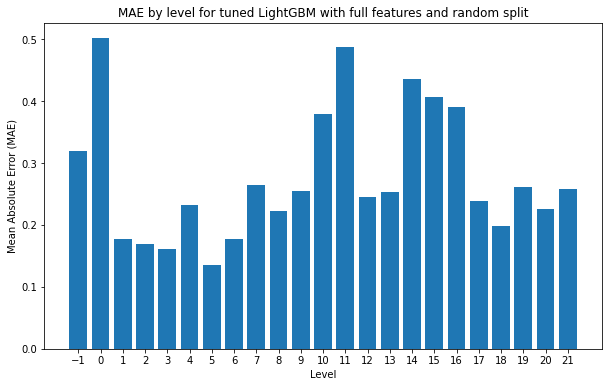

In [79]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with full features and random split",
)

In [80]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.03
RMSE: 0.17

Round type: round
MSE: 0.04
RMSE: 0.19

Round type: 0.33
MSE: 0.04
RMSE: 0.21

Round type: 0.45
MSE: 0.04
RMSE: 0.20



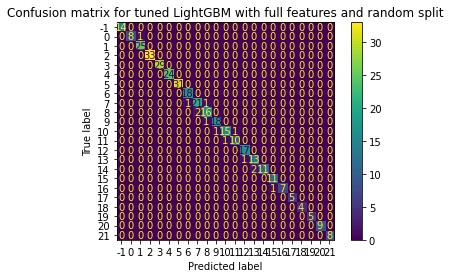

In [81]:
plot_confusion_matrix(
    "round",
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with full features and random split",
)

## Summary

In [82]:
results

,Split type,Tuning type,Set of features,MSE,RMSE,MAE
0,chronological,default,full,0.927292,0.962960,0.460853
1,chronological,Optuna,full,0.445614,0.667543,0.388662
2,random,default,full,0.137900,0.371349,0.246737
3,random,Optuna,full,0.097253,0.311854,0.222551


In [83]:
from training.results import plot_summary

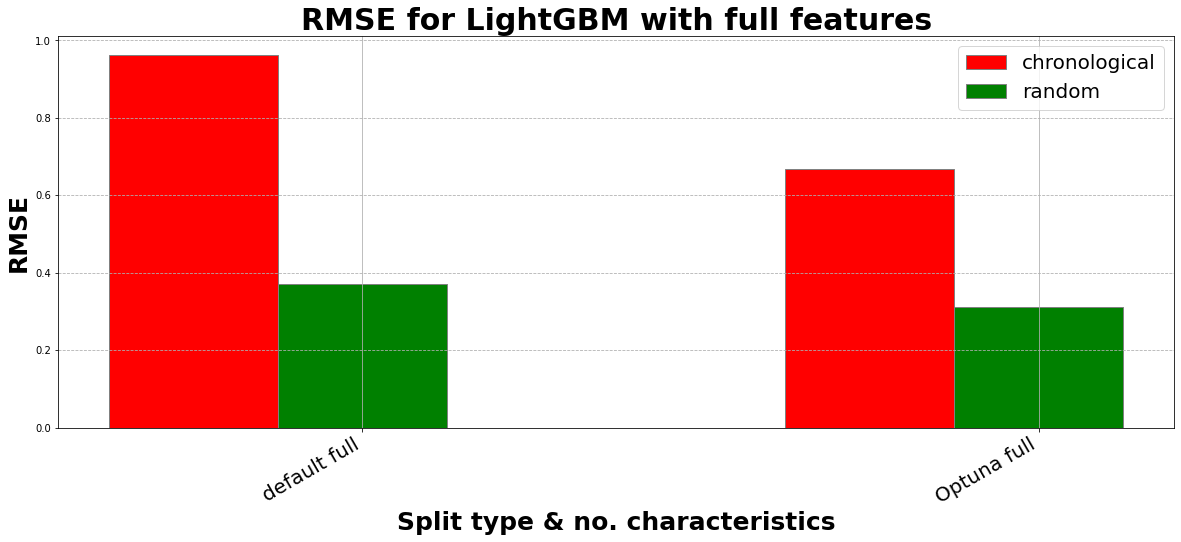

In [84]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with full features")

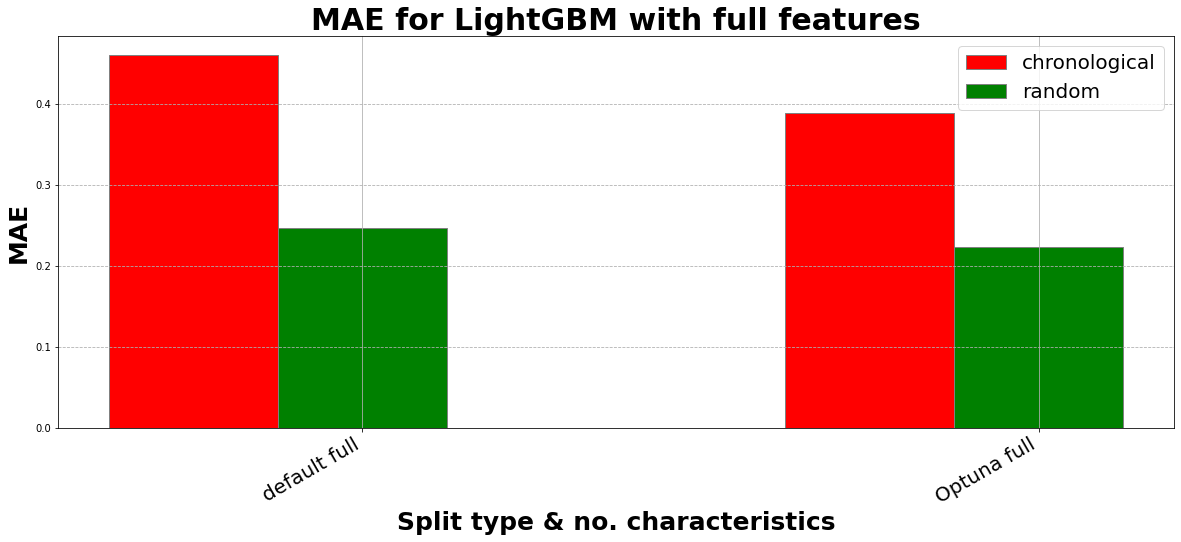

In [85]:
plot_summary(results, "MAE", title="MAE for LightGBM with full features")

In [86]:
results.to_json("./lightgbm_final_results.json")